# Predicting Dengue Cases
***

* Student name: ***Aysu Erdemir***
* Student pace: ***Flex***
* Scheduled project review date/time: ***March, 2023***
* Instructor name: ***Abhineet Kulkarni***

## Modeling:
***

The pre-processed cleaned dengue data with labels (1990-2008) was split into training and test sets using the first 80% of the data as train, and the final 20% for test. Additional dataset with climate features only (without the knowledge of true case counts)(2008-2013) was used to forecast upcoming case counts  for the best performing models.

Several versions of machine learning models were built, tuned and validated to be able to forecast the time series data:

* **Negative Binomial Regression** (multiple regression used for count data following the negative binomial). This method was chosen specifically because total_cases could be described by a negative binomial distribution with a population variance that is much larger than the population mean. 

* **Sarimax** (Seasonal Autoregressive Integrated Moving Average Exogenous model)- a generalization of an autoregressive moving average (ARMA) model which supports time series data with a seasonal component.

* **XGBoost (Extreme Gradient Boosting) Regression** Gradient-boosted decision tree algorithm used for regression predictive modeling.

* **LSTM (long short-term memory network)** A variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems.

## Evaluation:
***

* Performance is evaluated according to the **Mean Absolute Error**. 
* MAE is a popular metric to use as the error value is easily interpreted. This is because the value is on the same scale as the target we are predicting for.

### Import Necessary packages:

In [1]:
# Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
# Import packages for Negative Binomial regression
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

In [125]:
# Import packages for ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# !pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [4]:
# Import packages for XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [5]:
# Import packages for LSTM
# Directly download from keras without importing tensorflow, otherwise there are issues with using TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import random

In [6]:
# Import packages for model evaluation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

## Get the data ready for modeling:

In [7]:
# Import train_final and test_final
from google.colab import files
uploaded = files.upload()

Saving train_final.csv to train_final.csv
Saving test_final.csv to test_final.csv


In [8]:
# Read the Data
# drop the first unnamed column of repeated index  that was read. 
train_final = pd.read_csv("train_final.csv").iloc[:, 1:] 
test_final = pd.read_csv("test_final.csv").iloc[:, 1:]

In [9]:
# change `week_start_date` to datetime
train_final["week_start_date"] = pd.to_datetime(train_final["week_start_date"])
test_final["week_start_date"] = pd.to_datetime(test_final["week_start_date"])

# set the index to  `week_start_date` 
train_final = train_final.set_index("week_start_date")
test_final = test_final.set_index("week_start_date")

In [10]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 925 entries, 1990-07-16 to 2008-04-22
Data columns (total 41 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   total_cases                                     925 non-null    int64  
 1   year                                            925 non-null    float64
 2   weekofyear                                      925 non-null    float64
 3   month                                           925 non-null    int64  
 4   fall                                            925 non-null    int64  
 5   spring                                          925 non-null    int64  
 6   summer                                          925 non-null    int64  
 7   winter                                          925 non-null    int64  
 8   station_avg_temp_c                              925 non-null    float64
 9   station_max_temp_c      

In [11]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2008-04-29 to 2013-04-23
Data columns (total 40 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   year                                            260 non-null    float64
 1   weekofyear                                      260 non-null    float64
 2   month                                           260 non-null    int64  
 3   fall                                            260 non-null    int64  
 4   spring                                          260 non-null    int64  
 5   summer                                          260 non-null    int64  
 6   winter                                          260 non-null    int64  
 7   station_avg_temp_c                              260 non-null    float64
 8   station_max_temp_c                              260 non-null    float64
 9   station_min_temp_c      

Datasets include:

* 925 datapoints in train (which will be further split into train-test)
* 260 datapoints in final test

# Negative Binomial Regression:
***

* Our target variable, total_cases is a non-negative integer, which means we're looking to make some count predictions. Standard regression techniques for this type of prediction would include Poisson regression and Negative binomial regression.

* Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal. When they aren't, specifically when the variance is much larger than the mean, as is the case with current data - see below, the negative binomial approach is a better approach.

mean:  34.52540540540541
var : 2661.2885854685856


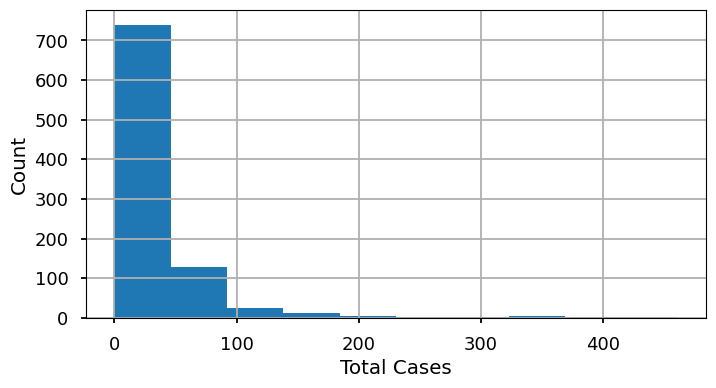

In [12]:
# Check the distribution of the target variable to see if it follows negative binomial distibution.
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8,4)) 
    train_final.total_cases.hist()
    ax.set_xlabel('Total Cases')
    ax.set_ylabel('Count')
print('mean: ', train_final.total_cases.mean())
print('var :', train_final.total_cases.var())

In [13]:
# create a copy of the train_final for NBR
train_NBR = train_final.copy()
train_NBR.head()

,total_cases,year,weekofyear,month,fall,spring,summer,winter,station_avg_temp_c,station_max_temp_c,...,watery_shift,station_max_temp_c_shift_18,station_min_temp_c_shift_18,station_avg_temp_c_shift_18,reanalysis_tdtr_k_shift_8,reanalysis_specific_humidity_g_per_kg_shift_12,reanalysis_precip_amt_kg_per_m2_shift_8,grassy_shift_20,soily_shift_20,watery_shift_20
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-07-16,2,1990.0,29.0,7,0,0,1,0,28.128571,32.8,...,0.0,32.990000,22.940000,27.584286,2.169643,16.840286,26.65000,0.300000,0.700000,0.0
1990-07-23,6,1990.0,30.0,7,0,0,1,0,28.114286,31.7,...,0.0,32.872727,22.827273,27.581818,2.151786,16.892857,28.85250,0.272727,0.727273,0.0
1990-07-30,17,1990.0,31.0,7,0,0,1,0,28.242857,34.4,...,0.0,32.866667,22.916667,27.627381,2.150000,16.963214,32.22750,0.333333,0.666667,0.0
1990-08-06,23,1990.0,32.0,8,0,0,1,0,28.200000,33.3,...,0.0,32.776923,22.907692,27.664835,2.032143,17.240595,36.01875,0.384615,0.615385,0.0
1990-08-13,13,1990.0,33.0,8,0,0,1,0,28.042857,32.8,...,0.0,32.892857,22.900000,27.706122,2.092857,17.425714,37.03250,0.428571,0.571429,0.0


### Train test split:
* Splitting data into train/test sets is to evaluate under- and overfitting and help to choose the hyperparameters.

In [14]:
# Set the first 80% of the data to train, and remaning 20% to test:
train = train_NBR.head(750)
test = train_NBR.tail(train_NBR.shape[0] - 750)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

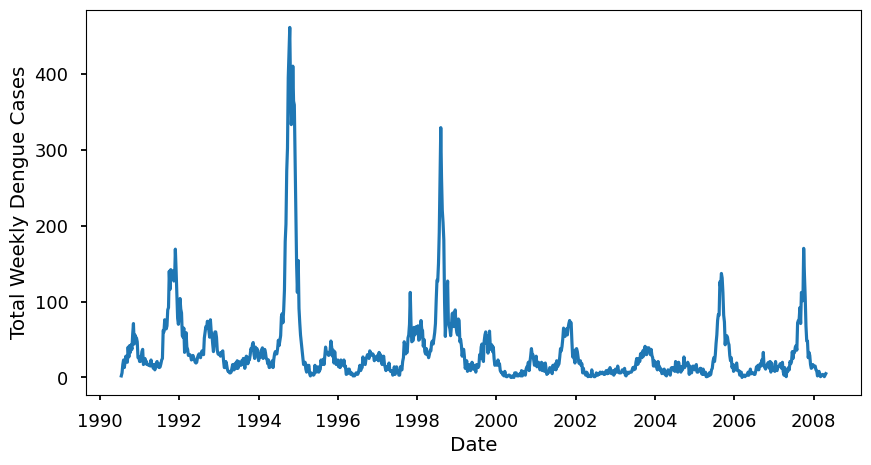

In [15]:
# Plot the distribution of case counts per each successive year for presentation:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train_NBR['total_cases'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Weekly Dengue Cases')
    fig.patch.set_alpha(0) # make the figure background transparent
    fig.savefig('total_cases_years.png', dpi=300)
    files.download("total_cases_years.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

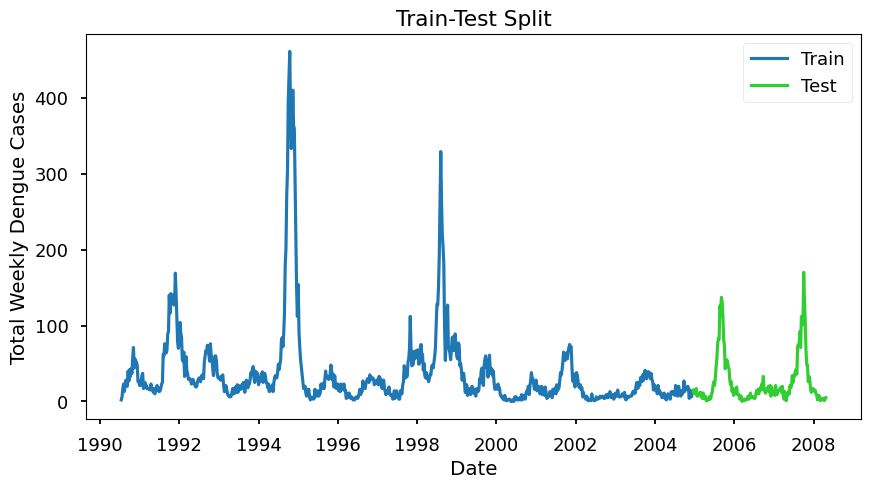

In [16]:
# Plot the distribution of case counts per each successive year for train and test data
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train['total_cases'], label='Train')
    ax.plot(test['total_cases'], label='Test', color = 'limegreen')
    ax.set_title('Train-Test Split')
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Weekly Dengue Cases')
    fig.patch.set_alpha(0) # make the figure background transparent
    plt.legend();
    fig.savefig('total_cases_test_train_split.png', dpi=300)
    files.download("total_cases_test_train_split.png") 

## Negative Binomial Regression Model #1
* A simple model with 4 original variables.

#### Create a function to get the best NBR model using the most optimum alpha that minimizes Mean Absolute Error:

In [17]:
def get_best_NBR_model(train, test, model_formula):

    # Create the aplha grid
    grid = np.linspace(0.000001, 2, 1000) # grid = np.arange(-8, -3, dtype=np.float64)
    best_alpha = []
    best_MAE_score = 1000
        
    # Find the best hyper parameter, alpha - specify the regularization distribution between L1 and L2.
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        
        predictions_test = results.predict(test).astype(int)
        score_test = eval_measures.meanabs(predictions_test, test.total_cases)
        
        if score_test < best_MAE_score:
            best_alpha = alpha
            best_MAE_score = score_test
            
    
    print('best alpha = ', best_alpha)
    print('(best) test MAE score = ', best_MAE_score)
    
    # refit on train dataset using best alpha
    model = smf.glm(formula=model_formula,
                    data=train,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))
    fitted_model = model.fit()

    predictions_train = fitted_model.predict(train).astype(int) 
    score_train = eval_measures.meanabs(predictions_train, train.total_cases)
    print('train MAE score = ', score_train)
    
    return fitted_model

In [18]:
# Create the model formula and run above function
model_formula = "total_cases ~ 1 + " \
                "station_avg_temp_c + " \
                "reanalysis_tdtr_k + " \
                "reanalysis_specific_humidity_g_per_kg + " \
                "reanalysis_precip_amt_kg_per_m2  " \

best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  1e-06
(best) test MAE score =  22.617142857142856
train MAE score =  29.001333333333335


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      745
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17211.
Date:                Mon, 10 Apr 2023   Deviance:                       30782.
Time:                        00:03:30   Pearson chi2:                 5.22e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9669
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.5271      0.146     -3.598      0.000      -0.814      -0.240
station_avg_temp_c                        0.1479      0.010     15.537      0.000       0.129       0.167
reanalysis_tdtr_k                        -0.3015      0.015    -20.405      0.000      -0.330      -0.273
reanalysis_specific_humidity_g_per_kg     0.0472      0.009      5.277      0.000       0.030       0.065
reanalysis_precip_amt_kg_per_m2           0.0014      0.000      9.855      0.000       0.001       0.002
=========================================================================================================
"""

* p values for all variables are below .05 and statistically significant,  meaning we have enough evidence in favor of the idea that temp, daily temp range, humidity and precipitation correlate with total cases.

#### Create a function to:
* (1) plot the true total cases against test and train predictions.
* (2) display the Mean Absolute Error and Root Mean Sqaure Error for both train and test. This helps to see the overall performance of the model on both train and test, and assess overfitting. 


In [19]:
# Plot true total cases against train and test predictions:
def forecast_graph(observed, predictions_train, predictions_test):

    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(14,6)) 
        ax.plot(observed, label='observed')
        ax.plot(predictions_train, label='train - fitted') 
        ax.plot(predictions_test, label='test - forecasted') 
        ax.set_title("Dengue Predicted Cases vs. Actual Cases")
        ax.set_xlabel('Date')
        ax.set_ylabel('Total Cases')
        plt.legend(); 

In [20]:
# display the Mean Absolute Error and Root Mean Sqaure Error for both train and test
def final_scores(y_train_true, y_train_pred, y_test_true, y_test_pred):
    MAE_train = MAE(y_train_true, y_train_pred)
    MAE_test = MAE(y_test_true, y_test_pred)

    RMSE_train = MSE(y_train_true, y_train_pred, squared=False) # Setting squared to False will return the RMSE.
    RMSE_test = MSE(y_test_true, y_test_pred, squared=False)

    print('MAE_train: %f' % MAE_train)
    print('MAE_test: %f' % MAE_test)
    print('-----------------------')
    print('RMSE_train: %f' % RMSE_train)
    print('RMSE_test: %f' % RMSE_test)

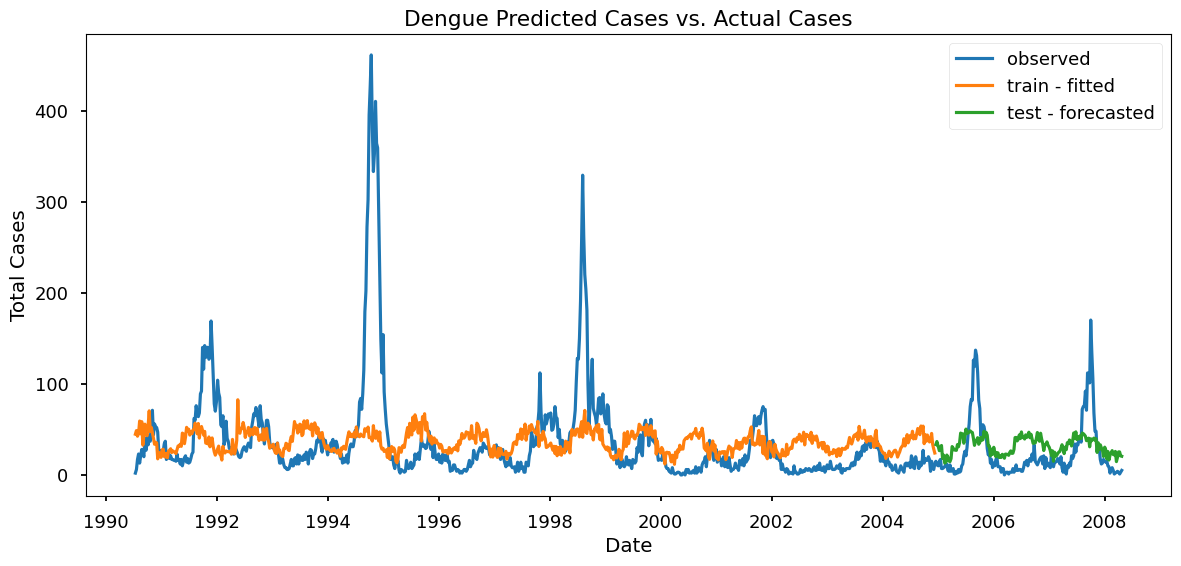

In [21]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [22]:
final_scores(train.total_cases, best_model.predict(train), test.total_cases, best_model.predict(test))

MAE_train: 29.173050
MAE_test: 22.943668
-----------------------
RMSE_train: 53.788695
RMSE_test: 30.244678


**Summary:**

* The model does not overfit that data given that train and test scores are not too different, however it only captures the basic seasonality, while missing all the individual ourbreaks - peaks. 

* Next let's see what happens when we add more variables.

## Negative Binomial Regression Model #2
* Add more variables

In [23]:
model_formula = "total_cases ~ 1 + " \
                "station_avg_temp_c + " \
                "station_max_temp_c + " \
                "station_min_temp_c + " \
                "reanalysis_tdtr_k + " \
                "reanalysis_specific_humidity_g_per_kg + " \
                "reanalysis_precip_amt_kg_per_m2 + " \
                "month "
  
best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  1e-06
(best) test MAE score =  21.017142857142858
train MAE score =  28.038666666666668


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      742
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15364.
Date:                Mon, 10 Apr 2023   Deviance:                       27086.
Time:                        00:04:06   Pearson chi2:                 4.10e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.5088      0.152     -3.337      0.001      -0.808      -0.210
station_avg_temp_c                       -0.0797      0.017     -4.633      0.000      -0.113      -0.046
station_max_temp_c                        0.2414      0.008     29.861      0.000       0.226       0.257
station_min_temp_c                       -0.0109      0.011     -1.020      0.308      -0.032       0.010
reanalysis_tdtr_k                        -0.3484      0.015    -22.924      0.000      -0.378      -0.319
reanalysis_specific_humidity_g_per_kg    -0.0725      0.010     -7.462      0.000      -0.092      -0.053
reanalysis_precip_amt_kg_per_m2           0.0008      0.000      4.951      0.000       0.000       0.001
month                                     0.1202      0.002     55.314      0.000       0.116       0.124
=========================================================================================================
"""

* p values for all variables except min temp are below .05 and statistically significant, meaning we have enough evidence in favor of the idea that these variables correlate with total cases.

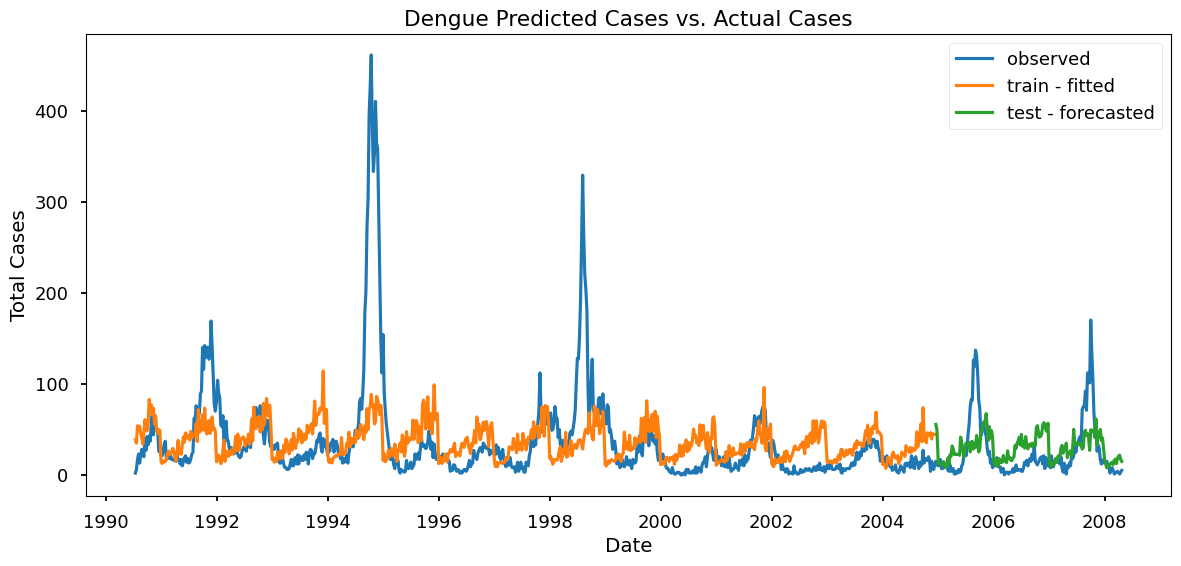

In [24]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [25]:
final_scores(train.total_cases, best_model.predict(train), test.total_cases, best_model.predict(test))

MAE_train: 28.226007
MAE_test: 21.302535
-----------------------
RMSE_train: 51.058028
RMSE_test: 30.007795


**Summary:**

* The model with more variables is a little better as the MAE and RMSE scores are slightly lower. 
* However, it still captures the basic seasonality only, while missing all the individual ourbreaks - peaks. 
* There is also some asyncrony between the onset each cycle representing true cases versus the predicted cases.
* Let's see if using time shifted variables will help.

## Negative Binomial Regression Model #3
* Use time shifted variables

In [26]:
model_formula = "total_cases ~ 1 + " \
                "station_max_temp_c_shift + " \
                "station_min_temp_c_shift + " \
                "station_avg_temp_c_shift + " \
                "reanalysis_tdtr_k_shift + " \
                "reanalysis_specific_humidity_g_per_kg_shift + " \
                "reanalysis_precip_amt_kg_per_m2_shift + " \
                "month +" \
                "grassy_shift +" \
                "watery_shift +" \
                "soily_shift" 
    
best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  0.0020030010010010013
(best) test MAE score =  20.405714285714286
train MAE score =  27.653333333333332


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      740
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13505.
Date:                Mon, 10 Apr 2023   Deviance:                       23319.
Time:                        00:04:48   Pearson chi2:                 3.58e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.6370      0.124     -5.126      0.000      -0.881      -0.393
station_max_temp_c_shift                        0.1841      0.009     21.584      0.000       0.167       0.201
station_min_temp_c_shift                        0.0655      0.011      5.815      0.000       0.043       0.088
station_avg_temp_c_shift                       -0.0418      0.018     -2.274      0.023      -0.078      -0.006
reanalysis_tdtr_k_shift                        -0.4561      0.016    -28.371      0.000      -0.488      -0.425
reanalysis_specific_humidity_g_per_kg_shift    -0.0909      0.010     -8.661      0.000      -0.111      -0.070
reanalysis_precip_amt_kg_per_m2_shift           0.0007      0.000      4.164      0.000       0.000       0.001
month                                           0.0992      0.003     38.799      0.000       0.094       0.104
grassy_shift                                   -0.3490      0.044     -7.863      0.000      -0.436      -0.262
watery_shift                                   -0.2550      0.043     -5.985      0.000      -0.338      -0.171
soily_shift                                    -0.0330      0.044     -0.752      0.452      -0.119       0.053
===============================================================================================================
"""

* p values for all variables except soily_shift are below 0.05 and statistically significant,  meaning we have enough evidence in favor of the idea that these variables correlate with total cases.

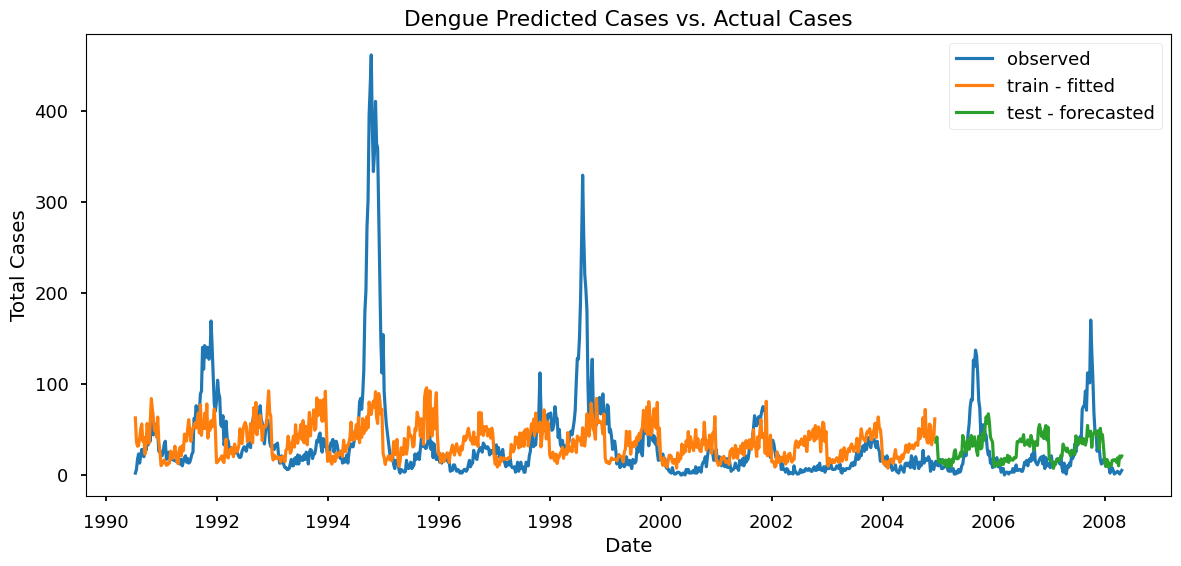

In [27]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [28]:
final_scores(train.total_cases, best_model.predict(train), 
             test.total_cases, best_model.predict(test))

MAE_train: 27.839518
MAE_test: 20.656355
-----------------------
RMSE_train: 50.823396
RMSE_test: 29.647056


**Summary:**

* This model slightly better as the MAE and RMSE scores are slightly lower. 
* The asyncrony is slighlty less pronounced in this model but it is still not sufficient. Using time shifted variables did not help much. 
* It still captures the basic seasonality only, while missing all the individual ourbreaks - peaks. 
* Let's see what happens when we use the lagged variables this time.

## Negative Binomial Regression Model #4
* Use time sfifted variables with most highly correlated lagged means to account for sustained heat, humidity, precipitation and vegetation. 

In [29]:
model_formula = "total_cases ~ 1 + " \
                "station_max_temp_c_shift_18 + " \
                "station_min_temp_c_shift_18 + " \
                "station_avg_temp_c_shift_18 + " \
                "reanalysis_tdtr_k_shift_8 + " \
                "reanalysis_specific_humidity_g_per_kg_shift_12 + " \
                "reanalysis_precip_amt_kg_per_m2_shift_8 + " \
                "fall +" \
                "spring +" \
                "winter +" \
                "summer +" \
                "grassy_shift_20 +" \
                "soily_shift_20 +" \
                "watery_shift_20" \
    
best_model = get_best_NBR_model(train, test, model_formula)
best_model.summary()

best alpha =  1e-06
(best) test MAE score =  15.771428571428572
train MAE score =  20.158666666666665


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  750
Model:                            GLM   Df Residuals:                      738
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8939.3
Date:                Mon, 10 Apr 2023   Deviance:                       14238.
Time:                        00:06:35   Pearson chi2:                 1.84e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -9.9703      0.246    -40.590      0.000     -10.452      -9.489
station_max_temp_c_shift_18                        1.4173      0.031     45.622      0.000       1.356       1.478
station_min_temp_c_shift_18                        2.2127      0.038     58.632      0.000       2.139       2.287
station_avg_temp_c_shift_18                       -2.4829      0.062    -40.011      0.000      -2.605      -2.361
reanalysis_tdtr_k_shift_8                         -0.5996      0.028    -21.653      0.000      -0.654      -0.545
reanalysis_specific_humidity_g_per_kg_shift_12    -0.4644      0.016    -29.577      0.000      -0.495      -0.434
reanalysis_precip_amt_kg_per_m2_shift_8           -0.0037      0.000     -8.484      0.000      -0.005      -0.003
fall                                              -2.3035      0.074    -30.927      0.000      -2.449      -2.158
spring                                            -2.5182      0.052    -48.305      0.000      -2.620      -2.416
winter                                            -2.6845      0.067    -40.275      0.000      -2.815      -2.554
summer                                            -2.4641      0.061    -40.504      0.000      -2.583      -2.345
grassy_shift_20                                   -3.4037      0.102    -33.440      0.000      -3.603      -3.204
soily_shift_20                                    -2.4105      0.106    -22.803      0.000      -2.618      -2.203
watery_shift_20                                   -4.1560      0.087    -47.657      0.000      -4.327      -3.985
==================================================================================================================
"""

* Using the lagged variables p values for all 13 variables are below 0.05 and statistically significant. 

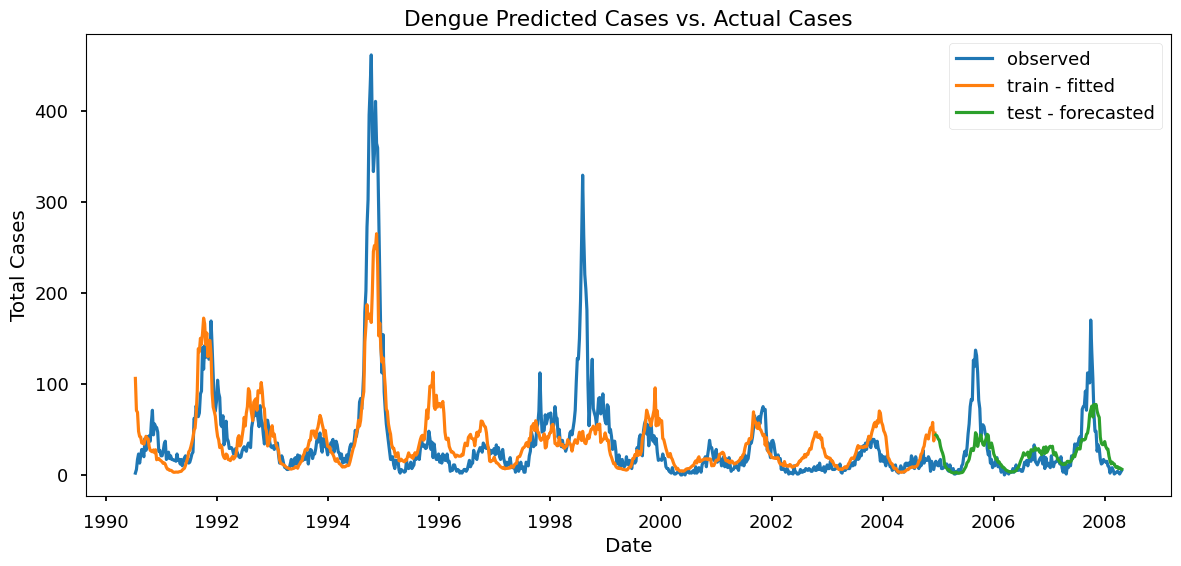

In [30]:
forecast_graph(train_NBR.total_cases, best_model.predict(train), best_model.predict(test))

In [31]:
final_scores(train.total_cases, best_model.predict(train), test.total_cases, best_model.predict(test))

MAE_train: 20.243531
MAE_test: 15.921087
-----------------------
RMSE_train: 36.521933
RMSE_test: 25.074627


**Summary:**

* This model is significantly better as the MAE and RMSE scores are significantly lower. 
* This model captures some of the individual peaks-outbreak correctly and it generalizes to the test set much better as well. 
* The model does not seem to overfit since teh train and test scores are close to one another. 

## Refit on the whole dataset for feature importance and forecasting into future :
* Once we have done enough iterations and we are satisfied with the performance, we can retrain your model on the total labeled data to get maximal performance for 
  * feature importance and 
  * forecasting into the future with final test set, for which we do not have the true case counts available.

In [32]:
# refit on the whole data set 
model = smf.glm(formula=model_formula,
                    data=train_NBR,
                    family=sm.families.NegativeBinomial(alpha=1e-06))
fitted_model = model.fit()

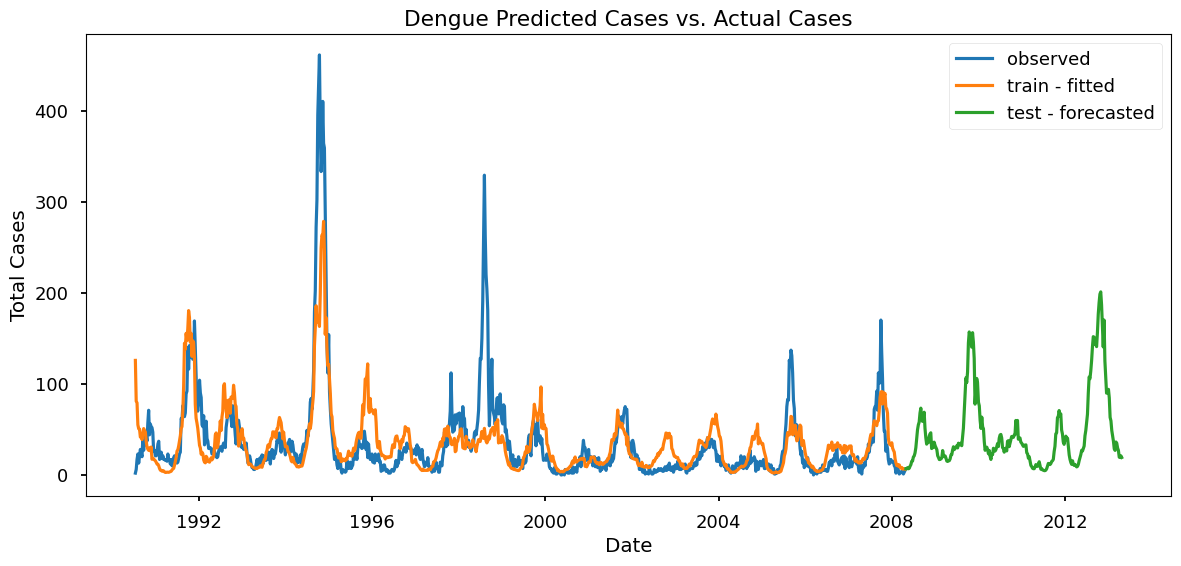

In [33]:
forecast_graph(train_NBR.total_cases, fitted_model.predict(train_NBR), fitted_model.predict(test_final))

By refitting the model on the whole train set and projecting on to future, we see that there are two more moderate size outbreaks predicted by the end of year 2009 and 2012. 

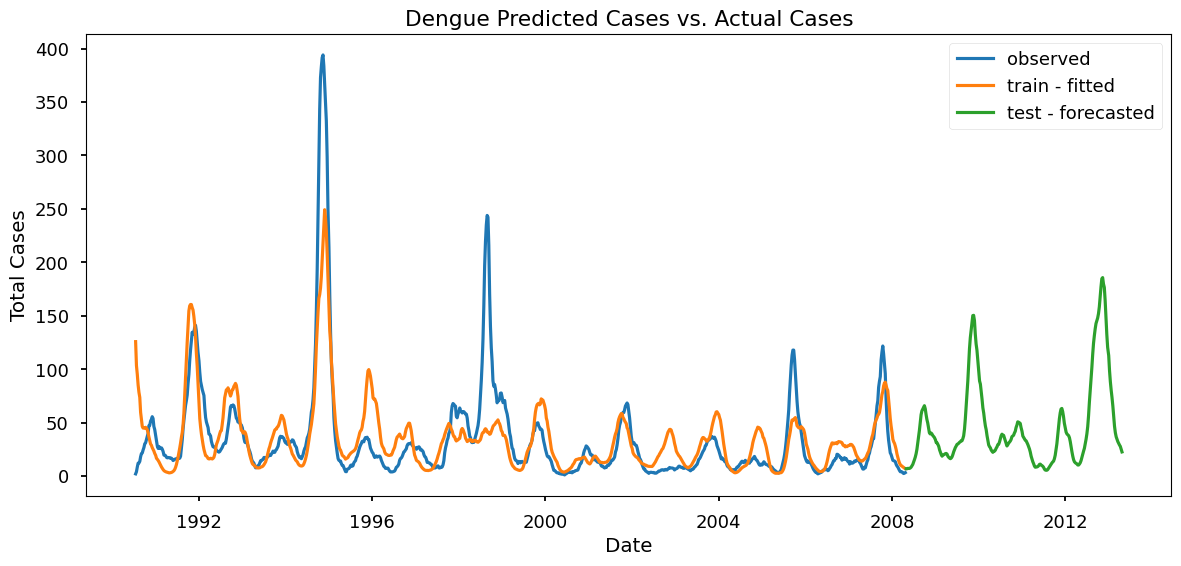

In [34]:
# Create a smoother version of the above graph:
total_cases_rolled = train_NBR.total_cases.rolling(window=6, min_periods = 1).mean()
predicted_train_final_rolled = fitted_model.predict(train_NBR).rolling(window=6, min_periods = 1).mean()
predicted_test_final_rolled = fitted_model.predict(test_final).rolling(window=6, min_periods = 1).mean()

forecast_graph(total_cases_rolled, predicted_train_final_rolled, predicted_test_final_rolled)

### Extract Feature importance from the final model:

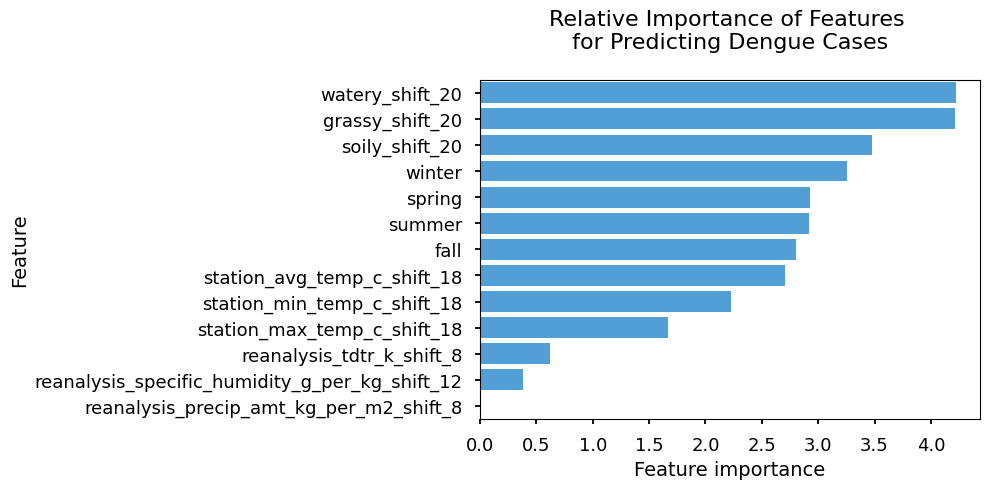

In [35]:
# Drop the model coefficient for graphing purposes:
coeff = fitted_model.params.drop('Intercept')

# Sort the coefficients: 
coeff = coeff.abs().sort_values(ascending=False) # if you want to keep - or +: coeff = coeff.iloc[(coeff.abs()*-1.0).argsort()]
# extract the index representing variable names
feature_names = pd.DataFrame(coeff).index

# Plot the coefficients using a TORNADO PLOT:
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette("husl", 9)[6]
    fig, ax  = plt.subplots(figsize=(10, 5))
    sns.barplot(x=coeff.values, y=coeff.index, color = base_color, ax=ax, orient='h')
    ax.set_title("Relative Importance of Features \n for Predicting Dengue Cases \n", fontsize=16) 
    ax.set_xlabel("Feature importance", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.set_yticklabels(labels=feature_names)
    fig.tight_layout();  
    # fig.savefig('./images/TornadoPlot_Coefs.png', dpi=300)

* Accorading to Negative Binomial Regression the most important features for predicting dengue cases are the NDVI variables followed by the individual seasons. 

# SARIMA
***

In [36]:
train_ARIMA = train_final.copy()

### RE-SAMPLE the time series dataset from **weekly** to **monthly**:
* This step was necessary since hyperparameter search with pm.auto_arima did not work efficiently on weekly data - for which the seasonality was set to 52 initially. 

In [37]:
train_ARIMA= train_ARIMA.resample('1M').mean()
train_ARIMA
# We are down to 214 rows.

,total_cases,year,weekofyear,month,fall,spring,summer,winter,station_avg_temp_c,station_max_temp_c,...,watery_shift,station_max_temp_c_shift_18,station_min_temp_c_shift_18,station_avg_temp_c_shift_18,reanalysis_tdtr_k_shift_8,reanalysis_specific_humidity_g_per_kg_shift_12,reanalysis_precip_amt_kg_per_m2_shift_8,grassy_shift_20,soily_shift_20,watery_shift_20
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-07-31,8.333333,1990.0,30.0,7.0,0.0,0.0,1.0,0.0,28.161905,32.966667,...,0.00,32.909798,22.894646,27.597828,2.157143,16.898786,29.243333,0.302020,0.697980,0.0000
1990-08-31,21.250000,1990.0,33.5,8.0,0.0,0.0,1.0,0.0,28.310714,32.900000,...,0.00,32.875570,22.913277,27.717010,2.104464,17.463720,37.863438,0.397047,0.602953,0.0000
1990-09-30,27.750000,1990.0,37.5,9.0,1.0,0.0,0.0,0.0,28.400000,33.075000,...,0.00,33.029657,23.124183,27.936006,2.325893,17.863095,41.957500,0.457473,0.542527,0.0000
1990-10-31,42.400000,1990.0,42.0,10.0,1.0,0.0,0.0,0.0,27.954286,32.980000,...,0.00,33.142222,23.448889,28.242063,2.439286,17.999024,46.427500,0.590000,0.410000,0.0000
1990-11-30,56.000000,1990.0,46.5,11.0,1.0,0.0,0.0,0.0,27.253571,32.225000,...,0.00,32.968056,23.409722,28.174603,2.263393,18.081935,78.978750,0.575000,0.425000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31,14.750000,2007.0,50.5,12.0,0.0,0.0,0.0,1.0,25.442857,28.875000,...,0.75,32.277778,23.591667,27.821032,2.646429,17.372321,43.128750,0.050000,0.737500,0.2125
2008-01-31,12.600000,2008.0,3.0,1.0,0.0,0.0,0.0,1.0,24.780000,28.440000,...,0.20,31.272222,23.035556,27.024603,2.438214,16.465048,39.525500,0.030000,0.690000,0.2800
2008-02-29,5.250000,2008.0,7.5,2.0,0.0,0.0,0.0,1.0,24.664286,27.900000,...,0.25,30.031944,22.241667,26.101389,2.435268,15.370804,25.243125,0.000000,0.650000,0.3500


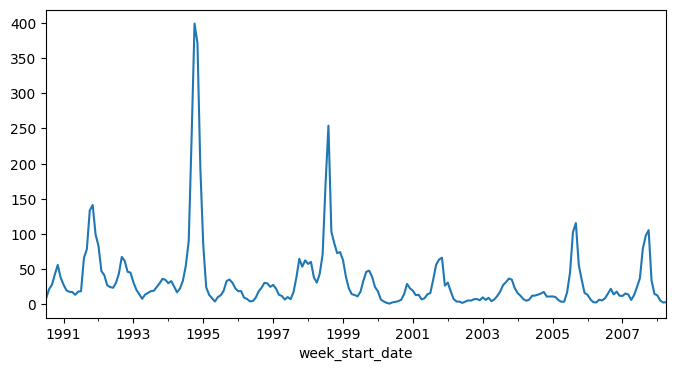

In [38]:
train_ARIMA.total_cases.plot(figsize=(8,4));
# we preserved the same shape

### Plot the ACF (auto correlation function) and PACF (partial auto correlation function):

* Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and results in a correlation of 1.
* The partial autocorrelation function can be interpreted as a regression of the series against its past lags. It helps us come up with a possible order for the auto regressive term.
* To figure out the order of an AR model, we need to look at the PACF.
* To figure out the order of an MA model, we need to look at the ACF.

In [39]:
trainseasonal = train_ARIMA['total_cases']

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


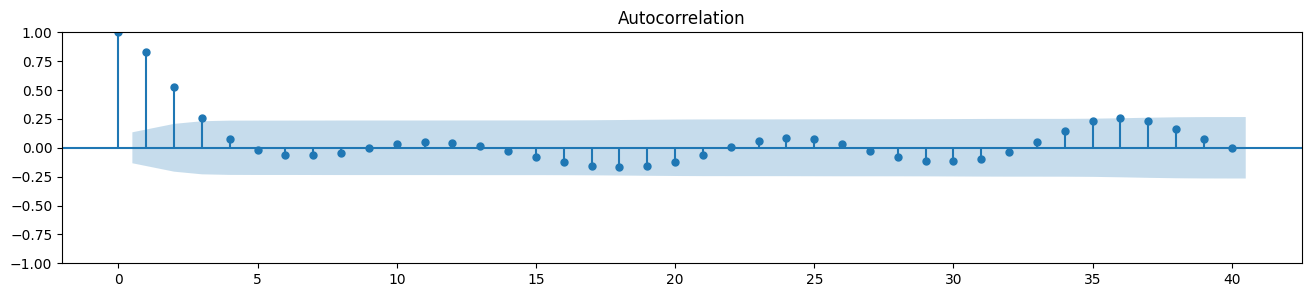

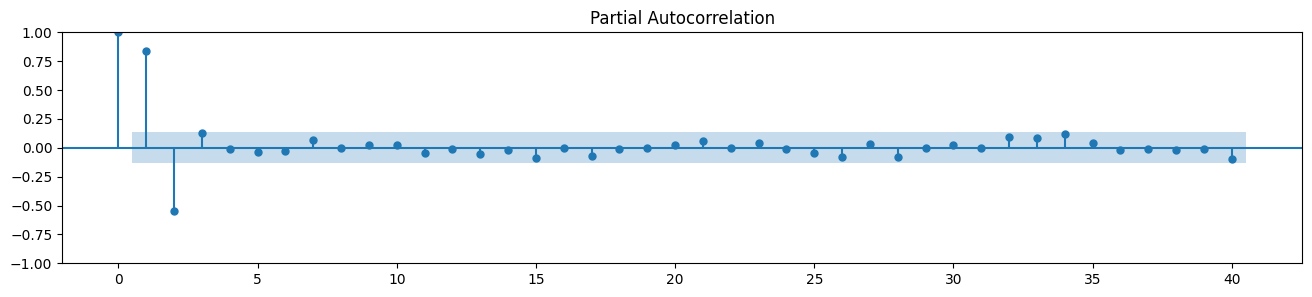

In [40]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(trainseasonal, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(trainseasonal, ax=ax, lags=40);

* There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
* High degree of autocorrelation between adjacent (lag = 1) and near-adjacent (lag = 2) observations in both ACF and PACF plots
* Based on the graphs above AR term can be 1 or 2, and the MA term could be 1 or 2 or 3. 

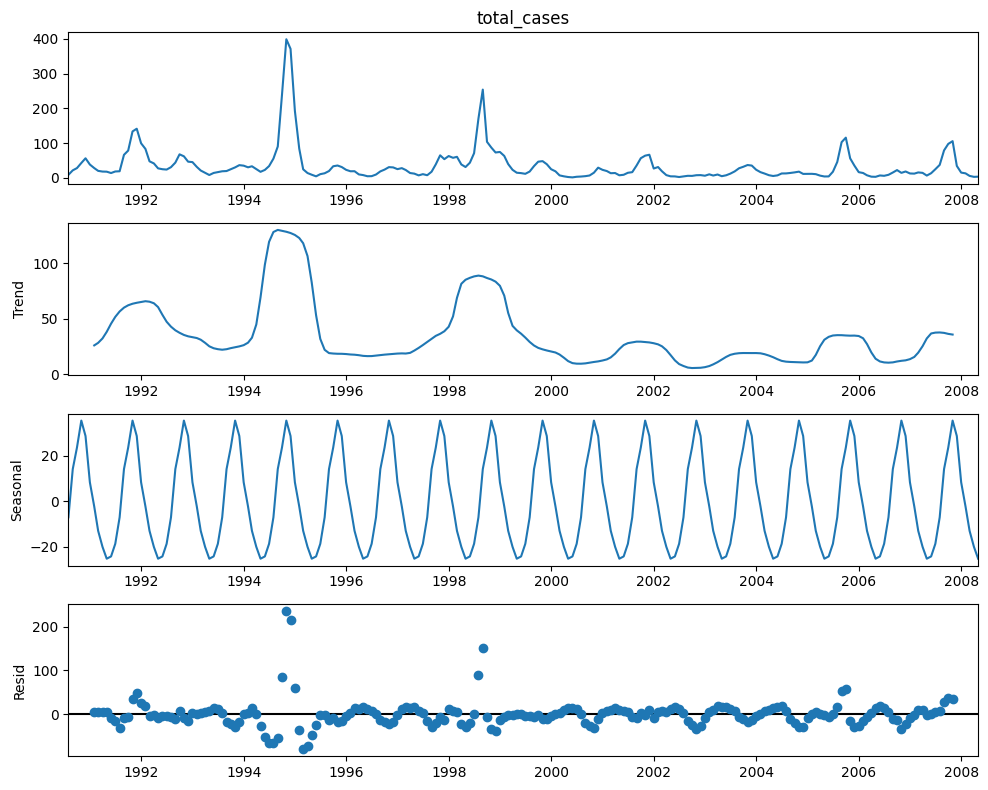

In [41]:
# Plot seasonality and trends:
# Since I’m working with monthly data, setting the frequency to 12 seems logical.
result = seasonal_decompose(trainseasonal, period = 12, model='additive')
fig = result.plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

* We can see the seasonality clearly, but there does not seem to be a strong trend in the data. 
* Let's check for stationarity using a statistical test:

In [42]:
# Statistical test to see if the time series is stationary or not
adf_test = ADFTest(alpha = .05)
adf_test.should_diff(trainseasonal)

(0.01, False)

* The results suggest that there is evidence to support that the series is stationary at a significance level of 0.05
* should_diff is False, indicating that we can conclude that the series is already stationary without differencing
* set d and D to zero in Sarimax.


# SARIMA #1 Baseline Model:
* Using only total cases as the predictor variable.

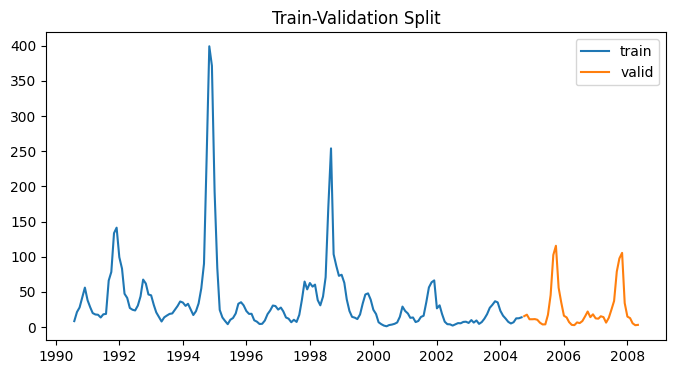

In [43]:
# Test-train split
train = train_ARIMA['total_cases'].head(170)
test = train_ARIMA['total_cases'].tail(train_ARIMA.shape[0] - 170)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train, label='train')
ax.plot(test, label='valid')
ax.set_title('Train-Validation Split')
plt.legend();

### Parameter Search:

A seasonal ARIMA model is classified as an ARIMA(p,d,q)x(P,D,Q) model,

* **p** = number of autoregressive (AR) terms 
* **d** = number of differences 
* **q** = number of moving average (MA) terms

* **P** = number of seasonal autoregressive (SAR) terms 
* **D** = number of seasonal differences 
* **Q** = number of seasonal moving average (SMA) terms


Using the auto_arima() function from the pmdarima package, we can perform a parameter search for the optimal values of the model.

In [44]:
# Parameter Search
sarimax_best = auto_arima(train,  
                          start_p=1, start_q=1, max_p=2, max_q=3,  
                          d=0, D=0,
                          start_P=1, start_Q=1, max_P=2, max_Q=3, 
                          m=12, 
                          max_order=None, 
                          error_action='ignore', 
                          suppress_warnings=True,
                          trace=True, 
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1839.716, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1640.132, Time=0.71 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1685.038, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1904.110, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1638.829, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1640.216, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1583.364, Time=0.14 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1585.330, Time=0.46 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=1585.331, Time=0.35 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=1587.331, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1582.492, Time=0.14 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1584.337, Time=0.71 sec
 ARIMA(2,0,1)(0,0,1)[12] inte

In [45]:
# Creating and fitting Final SARIMAX model
Final_model = SARIMAX(train.astype('int'),
                    order=sarimax_best.order,
                    seasonal_order=sarimax_best.seasonal_order,
                    enforce_invertibility=False)
                    #enforce_stationarity=True)
Final_output = Final_model.fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  170
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -792.738
Date:                Mon, 10 Apr 2023   AIC                           1593.475
Time:                        00:06:50   BIC                           1606.018
Sample:                    07-31-1990   HQIC                          1598.565
                         - 08-31-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0974      0.142      7.741      0.000       0.820       1.375
ar.L2         -0.2937      0.146     -2.009      0.045      -0.580      -0.007
ma.L1          0.3112      0.156      1.989      0.047       0.005       0.618
sigma2       649.1096     26.517     24.479      0.000     597.136     701.083
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              1994.16
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

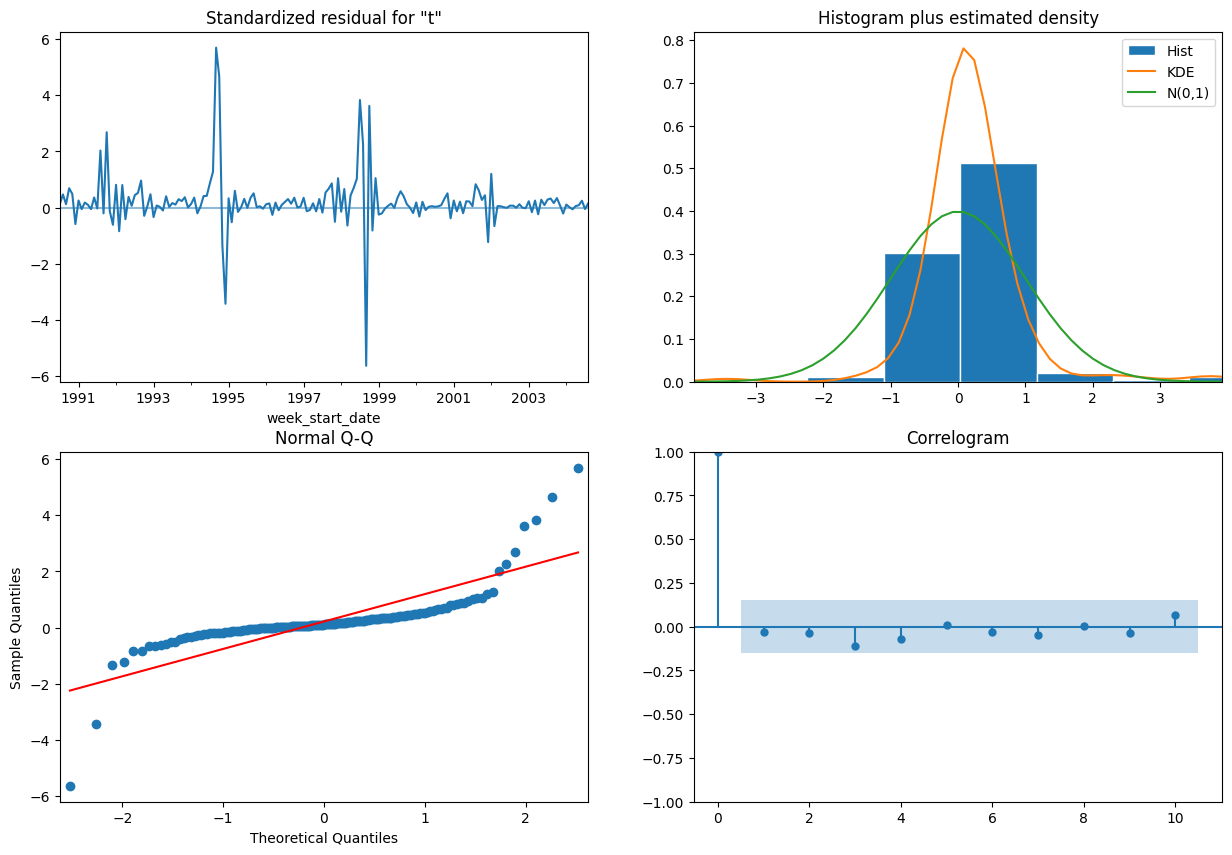

In [46]:
# Displaying the model summary and diagnostics
display(Final_output.summary());
Final_output.plot_diagnostics(figsize=(15, 10));

There does not seem to be any violation of assumptions for the model.

In [47]:
# Create predictions for train and test
train_prediction =  Final_output.predict(typ='levels') # sari_mod.predict(start=train.index[0], end=train.index[-1]
test_prediction =  Final_output.predict(start=test.index[0], end=test.index[-1],typ='levels')

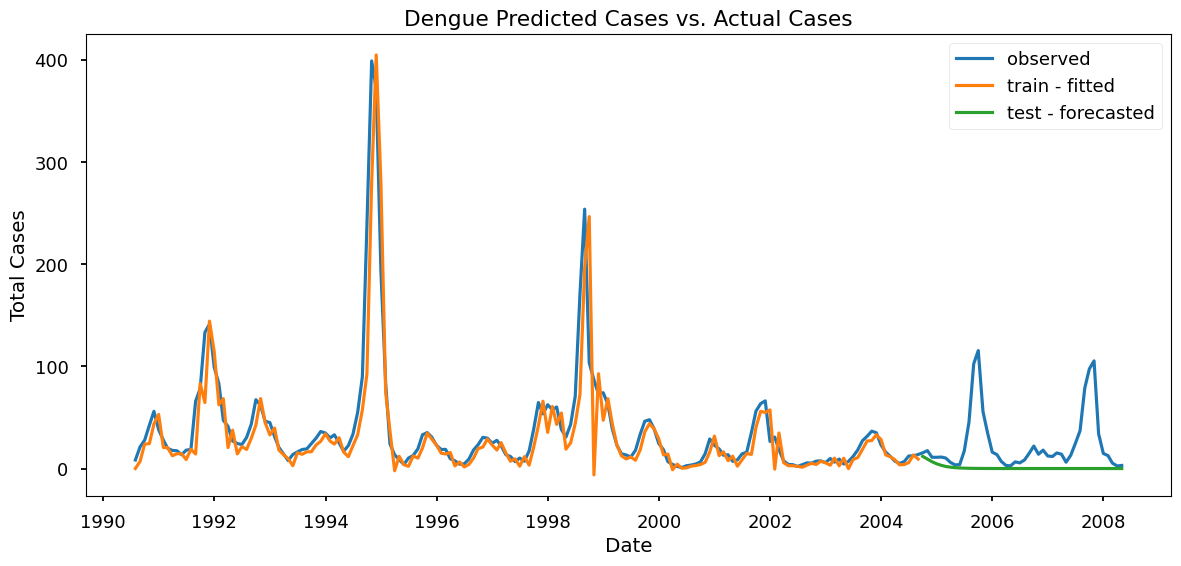

In [48]:
forecast_graph(train_ARIMA.total_cases, train_prediction, test_prediction)

In [49]:
final_scores(train, train_prediction, test, test_prediction)

MAE_train: 12.453838
MAE_test: 23.619172
-----------------------
RMSE_train: 25.574852
RMSE_test: 38.116806


**Summary:**

* Basic Sarima clearly overfits the data. It fits to the train data almost perfectly while performing very poorly for the test set. 
* This can also be seen by the fact that train MAE and RMSE scores are way lower than the test MAE and RMSE scores.

# SARIMAX #2 Full Multivariate Model:
* Using the lagged variables as exogenous variables.

In [50]:
train_ARIMA2 =  train_ARIMA[['total_cases','month','station_avg_temp_c_shift_18',
                              'station_min_temp_c_shift_18','station_max_temp_c_shift_18',
                              'reanalysis_tdtr_k_shift_8',
                              'reanalysis_specific_humidity_g_per_kg_shift_12',
                              'reanalysis_precip_amt_kg_per_m2_shift_8', 'grassy_shift_20',
                              'soily_shift_20', 'watery_shift_20']]

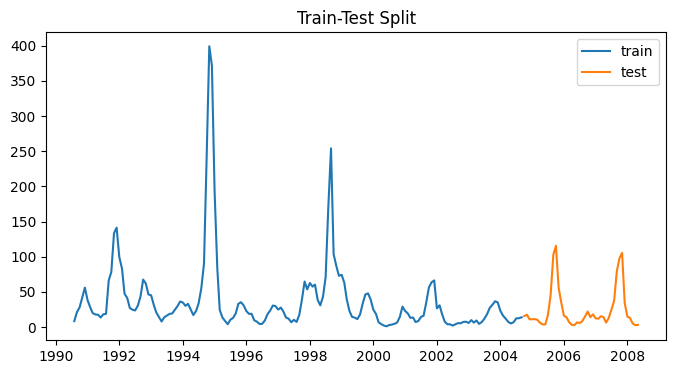

In [51]:
train = train_ARIMA2.head(170)
test = train_ARIMA2.tail(train_ARIMA2.shape[0] - 170)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train.total_cases, label='train')
ax.plot(test.total_cases, label='test')
ax.set_title('Train-Test Split')
plt.legend();

In [52]:
X_train, y_train, = train.drop('total_cases', axis=1), train['total_cases']
X_test, y_test = test.drop('total_cases', axis=1), test['total_cases']

In [53]:
exog_varbls =  ['month','station_avg_temp_c_shift_18',
                'station_min_temp_c_shift_18','station_max_temp_c_shift_18',
                'reanalysis_tdtr_k_shift_8',
                'reanalysis_specific_humidity_g_per_kg_shift_12',
                'reanalysis_precip_amt_kg_per_m2_shift_8', 'grassy_shift_20',
                'soily_shift_20', 'watery_shift_20']


In [54]:
endog_train = y_train
endog_test = y_test

### Reshape X_train and X_test into an array of exogenous regressors, shaped nobs x k:

In [55]:
exog_train = np.empty([len(X_train), len(exog_varbls)])
for i, var in zip(list(range(0,len(X_train))), exog_varbls):
    exog_train[:,i] = np.array(X_train[var])

In [56]:
exog_test = np.empty([len(X_test), len(exog_varbls)])
for i, var in zip(list(range(0,len(X_test))), exog_varbls):
    exog_test[:,i] = np.array(X_test[var])

In [57]:
exog_train.shape, exog_test.shape

((170, 10), (44, 10))

In [58]:
# Parameter Search
sarimax_best = auto_arima(y = endog_train, # target
                          X = exog_train,  # external predictors    
                          start_p=1, start_q=1, max_p=2, max_q=3,
                          d=0, D=0,
                          start_P=1, start_Q=1, max_P=2, max_Q=3, 
                          m=12, maxiter=50, 
                          max_order=None, 
                          error_action='ignore', 
                          suppress_warnings=True,
                          trace=True, 
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1788.617, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1637.232, Time=3.61 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1660.660, Time=1.90 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1786.617, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1635.306, Time=0.49 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1637.218, Time=1.72 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1599.759, Time=0.87 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1602.208, Time=3.33 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=1601.693, Time=2.77 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1598.549, Time=1.03 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1603.470, Time=2.66 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept

In [59]:
# Creating Final SARIMAX model
Final_model = SARIMAX(endog = endog_train,
                      exog = exog_train, # maxiter=100,  method='newton',
                      order=sarimax_best.order,
                      seasonal_order=sarimax_best.seasonal_order,
                      enforce_invertibility=False)
                      #enforce_stationarity=False)
Final_output = Final_model.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


This model does not converge. This might mean:
* Maybe the data is not well-suited for Sarima model order and parameter configuration.
* The initial parameter values may be too far from the true parameter values.
* For now we will continue with model summary and prediction but this model needs to be adjusted significantly. 



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  170
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -784.486
Date:                Mon, 10 Apr 2023   AIC                           1596.972
Time:                        00:07:42   BIC                           1640.873
Sample:                    07-31-1990   HQIC                          1614.786
                         - 08-31-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1643      1.031     -0.159      0.873      -2.186       1.857
x2           -75.5439     58.632     -1.288      0.198    -190.460      39.373
x3            76.0717     37.009      2.055      0.040       3.535     148.609
x4            44.6721     29.677      1.505      0.132     -13.494     102.839
x5             2.2828     24.116      0.095      0.925     -44.984      49.549
x6           -17.2832     11.957     -1.445      0.148     -40.719       6.152
x7             0.0107      0.341      0.031      0.975      -0.658       0.679
x8          -788.9876    291.318     -2.708      0.007   -1359.961    -218.014
x9          -768.1877    296.461     -2.591      0.010   -1349.240    -187.135
x10         -778.5248    292.666     -2.660      0.008   -1352.140    -204.910
ar.L1          0.9230      0.214      4.307      0.000       0.503       1.343
ar.L2         -0.2975      0.186     -1.597      0.110      -0.662       0.068
ma.L1          0.2911      0.224      1.297      0.195      -0.149       0.731
sigma2       608.8282     42.785     14.230      0.000     524.971     692.686
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1148.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

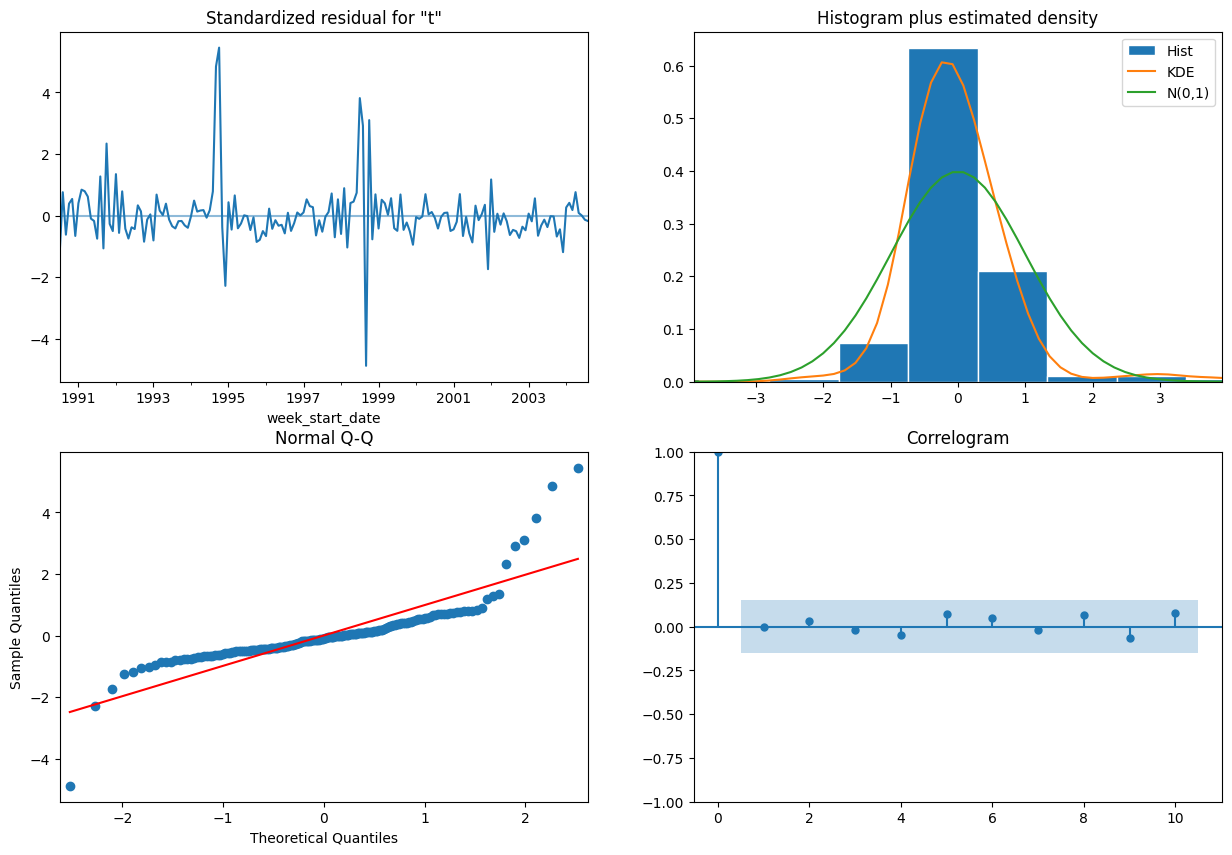

In [60]:
# Displaying the model summary and diagnostics
display(Final_output.summary());
Final_output.plot_diagnostics(figsize=(15, 10));

There does not seem to be any violation of assumptions for the model.

In [61]:
# Create Predictions:
train_prediction =  Final_output.predict(typ='levels', exog=exog_train) # sari_mod.predict(start=train.index[0], end=train.index[-1]
test_prediction =  Final_output.predict(start=test.index[0], end=test.index[-1],typ='levels', exog=exog_test)

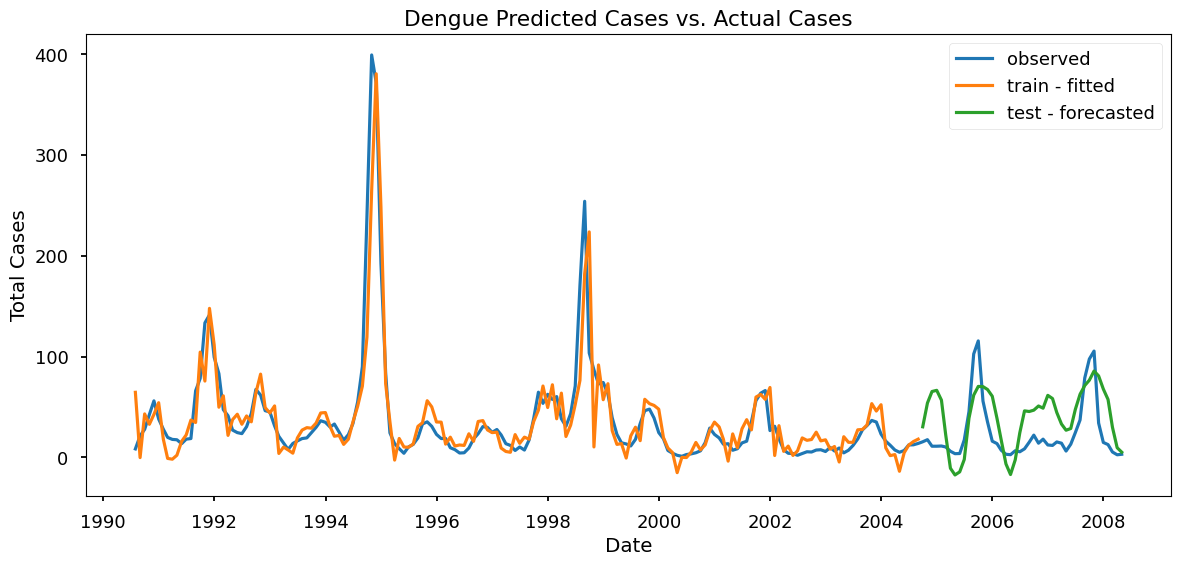

In [62]:
forecast_graph(train_ARIMA.total_cases, train_prediction, test_prediction)

In [63]:
final_scores(train.total_cases, train_prediction, test.total_cases, test_prediction)

MAE_train: 14.372901
MAE_test: 26.951134
-----------------------
RMSE_train: 24.593669
RMSE_test: 30.641963


**Summary:**

* Multivariate Sarima seems to perform better than the basic sarima. However it still does not differentially capture the two peaks in the test set. 
* While it performs very well for the train set, it does not generalize to unseen data.

# XGB Regression 
***

# Model #1:
* using original variables

In [64]:
# Re-assign a new dataset called train_XGB
train_XGB = train_final.copy()

In [65]:
# Create a subset of the dataset to use in modeling:
train_XGB1 = train_XGB[['total_cases', 
                        'month', 
                        'station_avg_temp_c', 'station_min_temp_c',
                        'station_max_temp_c', 'reanalysis_tdtr_k',
                        'reanalysis_specific_humidity_g_per_kg',
                        'reanalysis_precip_amt_kg_per_m2',
                        'grassy', 'soily', 'watery']]

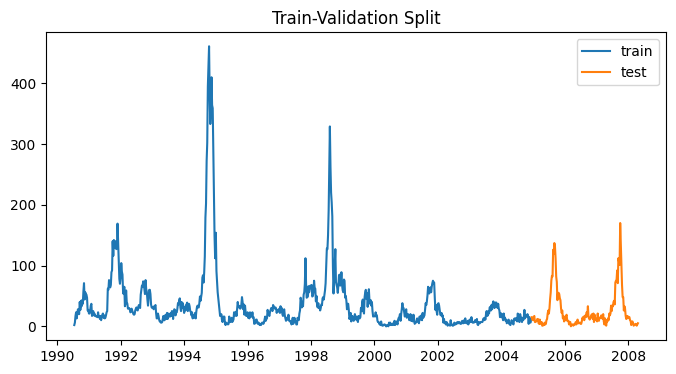

In [66]:
# Test-train split the dataset:
train = train_XGB1.head(750)
test = train_XGB1.tail(train_XGB1.shape[0] - 750)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train.total_cases, label='train')
ax.plot(test.total_cases, label='test')
ax.set_title('Train-Validation Split')
plt.legend();

In [67]:
# Create train and test X and y
X_train, y_train, = train.drop('total_cases', axis=1), train['total_cases']
X_test, y_test = test.drop('total_cases', axis=1), test['total_cases']

In [68]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 10), (750,), (175, 10), (175,))

In [69]:
# time split the dataset into 5 folds to be used in cross validation
time_split = TimeSeriesSplit(n_splits=5)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((125,), (125,)),
 ((250,), (125,)),
 ((375,), (125,)),
 ((500,), (125,)),
 ((625,), (125,))]

In [70]:
# initiate the regressor
model = xgb.XGBRegressor()

# Specify the tunable parameters
parameters = {'objective':['reg:squarederror','reg:absoluteerror','reg:squaredlogerror'],  # 'count:poisson'
              'learning_rate':[0.01, 0.05, 0.1, 0.2],   # default = 0.3, Lower ratios avoid over-fitting. 
              'max_depth': [2, 4, 6, 8],                # default = 6, Lower values avoid over-fitting.
              'min_child_weight': [1, 2, 3, 4],         # default = 1, Larger values avoid over-fitting. 
              'gamma':[0.5, 1],                         # default = 0, Larger values avoid over-fitting.
              'colsample_bytree':[0.5, 0.75],           # default = 1, Lower ratios avoid over-fitting.
              'subsample':[0.5, 0.75, 1]}               # default = 1, Lower ratios avoid over-fitting.

# Configure the GridSearchCV object to choose the best hyperparameters 
# Using the neg_mean_squared_error metric to compare the results of 5-fold cross-validation

xgb_grid = GridSearchCV(estimator = model,
                        cv = time_split,
                        param_grid = parameters,
                        scoring = 'neg_mean_squared_error', #eval_metric='logloss'
                        verbose=0)

# Train the best model
xgb_grid.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters:", xgb_grid.best_params_)
print("Best Score (MAE): ", (xgb_grid.best_score_))


Best parameters: {'colsample_bytree': 0.75, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'objective': 'reg:absoluteerror', 'subsample': 0.75}
Best Score (MAE):  -3116.6840740212792


In [71]:
# Create the train and test predictions as a DataFrame with index to use on the graph. 
# The best_estimator_ field contains the best model trained by GridSearch.
predicted_train = pd.DataFrame(xgb_grid.best_estimator_.predict(X_train), index= X_train.index)
predicted_test = pd.DataFrame(xgb_grid.best_estimator_.predict(X_test), index= X_test.index)

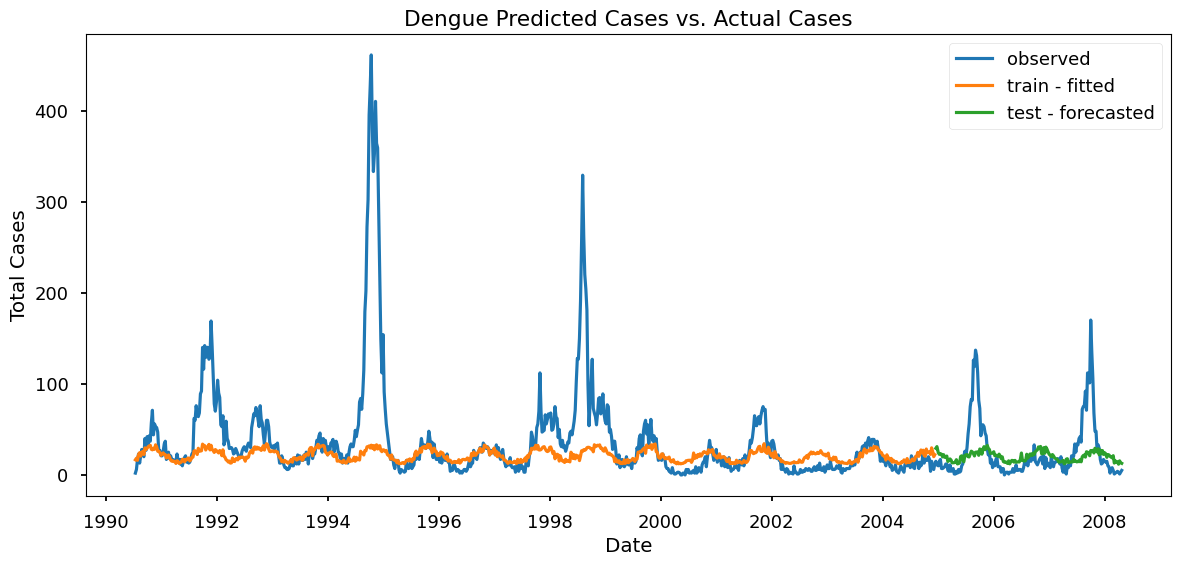

In [72]:
forecast_graph(train_XGB.total_cases, predicted_train, predicted_test)

In [73]:
# Print the scores for both train and test
final_scores(train.total_cases, xgb_grid.best_estimator_.predict(X_train), 
             test.total_cases, xgb_grid.best_estimator_.predict(X_test))

MAE_train: 22.316101
MAE_test: 18.996592
-----------------------
RMSE_train: 54.488551
RMSE_test: 30.858615


**Summary:**

* The model only captures seasonality, and does not capture the individual peaks-outbreaks.
* Let's try another model with the lagged variables which gave the best results with NBR. 

## Model #2 using the lagged variables:

In [74]:
train_XGB2 = train_XGB[['total_cases', 'month',
                        'station_avg_temp_c_shift_18', 'station_min_temp_c_shift_18',
                        'station_max_temp_c_shift_18', 'reanalysis_tdtr_k_shift_8',
                        'reanalysis_specific_humidity_g_per_kg_shift_12',
                        'reanalysis_precip_amt_kg_per_m2_shift_8',
                        'grassy_shift_20',
                        'soily_shift_20',
                        'watery_shift_20']]

In [75]:
train = train_XGB2.head(750)
test = train_XGB2.tail(train_XGB2.shape[0] - 750)

In [76]:
X_train, y_train, = train.drop('total_cases', axis=1), train['total_cases']
X_test, y_test = test.drop('total_cases', axis=1), test['total_cases']

In [77]:
time_split = TimeSeriesSplit(n_splits=5)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((125,), (125,)),
 ((250,), (125,)),
 ((375,), (125,)),
 ((500,), (125,)),
 ((625,), (125,))]

In [78]:
model = xgb.XGBRegressor()

# Specify the tunable parameters
parameters = {'objective':['reg:squarederror','reg:absoluteerror','reg:squaredlogerror'],  # 'count:poisson'
              'learning_rate':[0.01, 0.05, 0.1, 0.2],   # default = 0.3, Lower ratios avoid over-fitting. 
              'max_depth': [2, 4, 6, 8],                # default = 6, Lower values avoid over-fitting.
              'min_child_weight': [1, 2, 3, 4],         # default = 1, Larger values avoid over-fitting. 
              'gamma':[0.5, 1],                         # default = 0, Larger values avoid over-fitting.
              'colsample_bytree':[0.5, 0.75],           # default = 1, Lower ratios avoid over-fitting.
              'subsample':[0.5, 0.75, 1]}               # default = 1, Lower ratios avoid over-fitting.

# Configure the GridSearchCV object to choose the best hyperparameters 
# using the neg_mean_squared_error metric to compare the results of 5-fold cross-validation

xgb_grid = GridSearchCV(estimator = model,
                        cv = time_split,
                        param_grid = parameters,
                        scoring = 'neg_mean_squared_error', #eval_metric='logloss'
                        verbose=0)

# Train the best model
xgb_grid.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters:", xgb_grid.best_params_)
print("Best Score (MAE): ", (xgb_grid.best_score_))

Best parameters: {'colsample_bytree': 0.75, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'subsample': 0.5}
Best Score (MAE):  -2608.85466896299


In [79]:
# Create the train and test predictions as a DataFrame with index to use on the graph. 
predicted_train = pd.DataFrame(xgb_grid.best_estimator_.predict(X_train), columns= ['pred'], index= X_train.index)
predicted_test = pd.DataFrame(xgb_grid.best_estimator_.predict(X_test),columns= ['pred'], index= X_test.index)

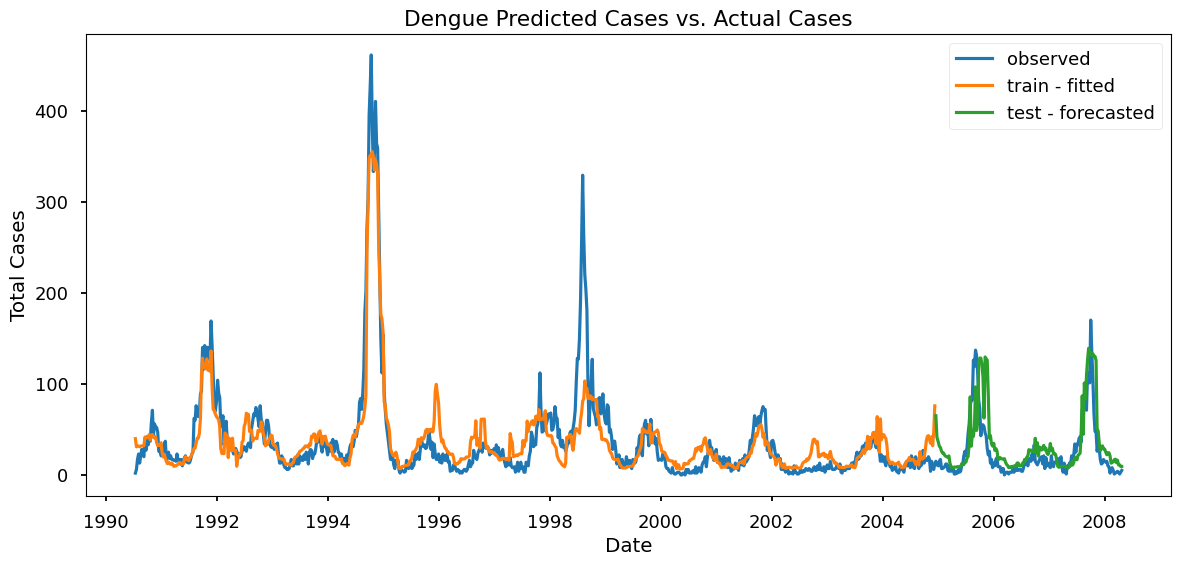

In [80]:
forecast_graph(train_XGB.total_cases, predicted_train, predicted_test)

In [81]:
# Print the scores for both train and test
final_scores(train.total_cases, xgb_grid.best_estimator_.predict(X_train), 
             test.total_cases, xgb_grid.best_estimator_.predict(X_test))

MAE_train: 14.660013
MAE_test: 17.724193
-----------------------
RMSE_train: 24.794945
RMSE_test: 26.477244


## Best performing model so far:
**Summary:**
* This model is by far the best model so far. It captures not only the seasonality but also the majority of the individual peaks. 
 * It performs similarly well for train and test, with weekly case count errors of 14.6 and 17.7, respectively, and generalizes well to unseen data by detecting the two peaks present between years 2005-2008.

In [82]:
# re-create the graph with smooth lines
total_cases_rolled = train_XGB.total_cases.rolling(window=4, min_periods = 1).mean()
predicted_train_rolled = predicted_train['pred'].rolling(window=4, min_periods = 1).mean()
predicted_test_rolled = predicted_test['pred'].rolling(window=4, min_periods = 1).mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

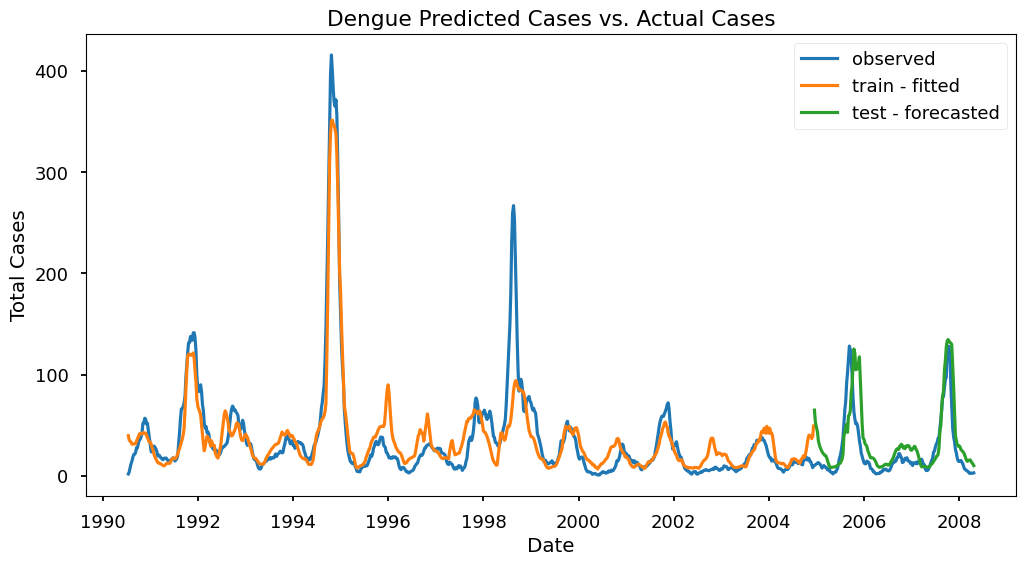

In [83]:
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(12,6)) 
  ax.plot(total_cases_rolled, label='observed')
  ax.plot(predicted_train_rolled, label='train - fitted') 
  ax.plot(predicted_test_rolled, label='test - forecasted') 
  ax.set_title("Dengue Predicted Cases vs. Actual Cases")
  ax.set_xlabel('Date')
  ax.set_ylabel('Total Cases')
  ax.xaxis.set_major_locator(mdates.YearLocator(2)) # Set the years on X axis apart by 2
  plt.legend()
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout();
  fig.savefig('XGB_Predict.png', dpi=300, bbox_inches='tight')
  files.download("XGB_Predict.png")  

## Refit on the whole dataset:

* Once we have done enough iterations and we are satisfied with the performance, we can retrain your model on the total labeled data to:
  - get maximal performance for forecasting into the future.
  - extract feature importances. 

In [84]:
# re-create X,y train:
X_train_whole, y_train_whole = train_XGB2.drop('total_cases', axis=1), train_XGB2['total_cases']

In [85]:
# get the same variables out from test_final
X_test_final = test_final[['month', 
                        'station_avg_temp_c_shift_18', 'station_min_temp_c_shift_18',
                        'station_max_temp_c_shift_18', 'reanalysis_tdtr_k_shift_8',
                        'reanalysis_specific_humidity_g_per_kg_shift_12',
                        'reanalysis_precip_amt_kg_per_m2_shift_8',
                        'grassy_shift_20',
                        'soily_shift_20',
                        'watery_shift_20']]

In [86]:
# Refit to the whole dataset using the best parameters:
model = xgb.XGBRegressor(objective='reg:squarederror',
                         learning_rate=0.05,
                         max_depth=2,
                         min_child_weight= 3,
                         subsample= 0.5,
                         colsample_bytree= 0.75, 
                         gamma= 0.5)

# Creating the model on Training Data
final_model = model.fit(X_train_whole,y_train_whole)

In [87]:
# Create predictions:
predicted_train_final = pd.DataFrame(final_model.predict(X_train_whole), columns= ['pred'], index= X_train_whole.index)
predicted_test_final = pd.DataFrame(final_model.predict(X_test_final), columns= ['pred'],  index= test_final.index)

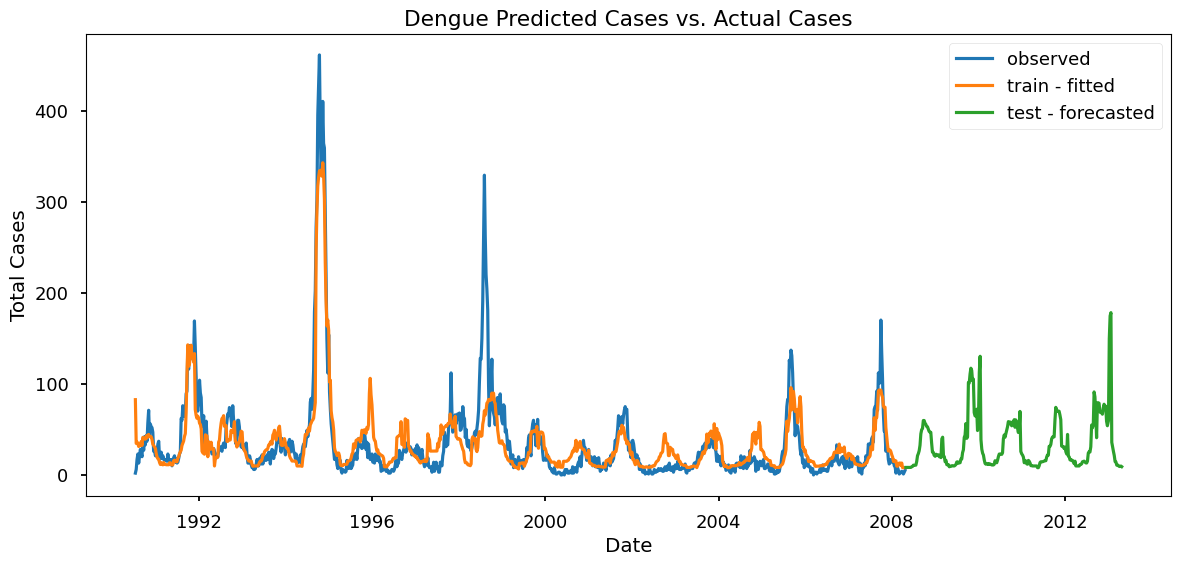

In [88]:
forecast_graph(train_XGB.total_cases, predicted_train_final, predicted_test_final)

In [89]:
# re-create the graph with smooth lines
total_cases_rolled = train_XGB.total_cases.rolling(window=4, min_periods = 1).mean()
predicted_train_final_rolled = predicted_train_final['pred'].rolling(window=4, min_periods = 1).mean()
predicted_test_final_rolled = predicted_test_final['pred'].rolling(window=4, min_periods = 1).mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

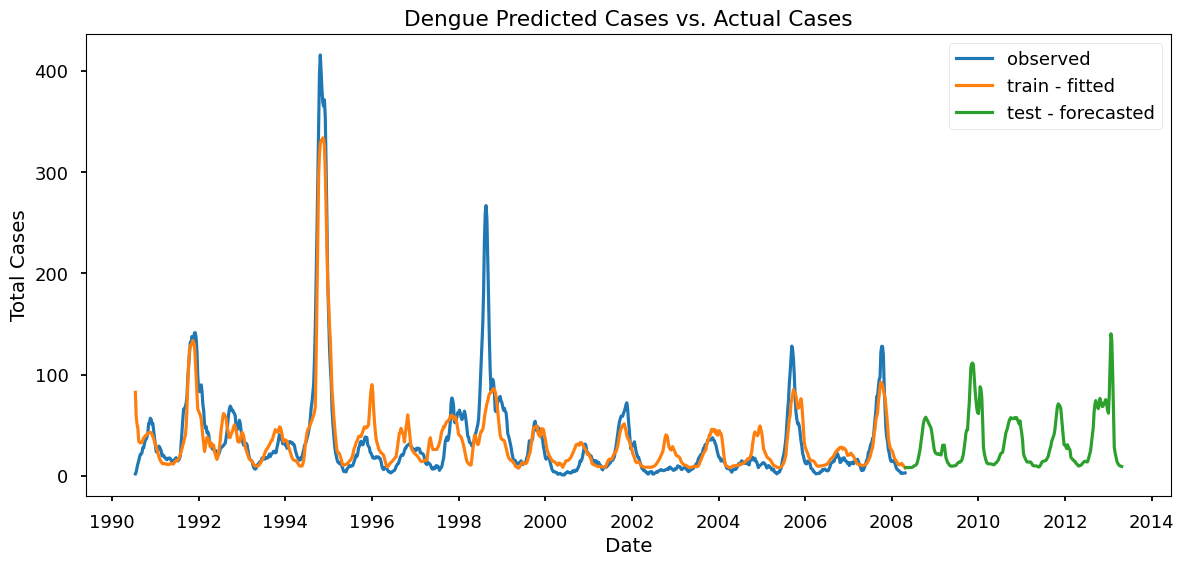

In [90]:
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(14,6)) 
  ax.plot(total_cases_rolled, label='observed')
  ax.plot(predicted_train_final_rolled, label='train - fitted') 
  ax.plot(predicted_test_final_rolled, label='test - forecasted') 
  ax.set_title("Dengue Predicted Cases vs. Actual Cases")
  ax.set_xlabel('Date')
  ax.set_ylabel('Total Cases')
  ax.xaxis.set_major_locator(mdates.YearLocator(2)) # Set the years on X axis apart by 2
  plt.legend()
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout();
  fig.savefig('XGB_Forecast.png', dpi=300, bbox_inches='tight')
  files.download("XGB_Forecast.png")       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

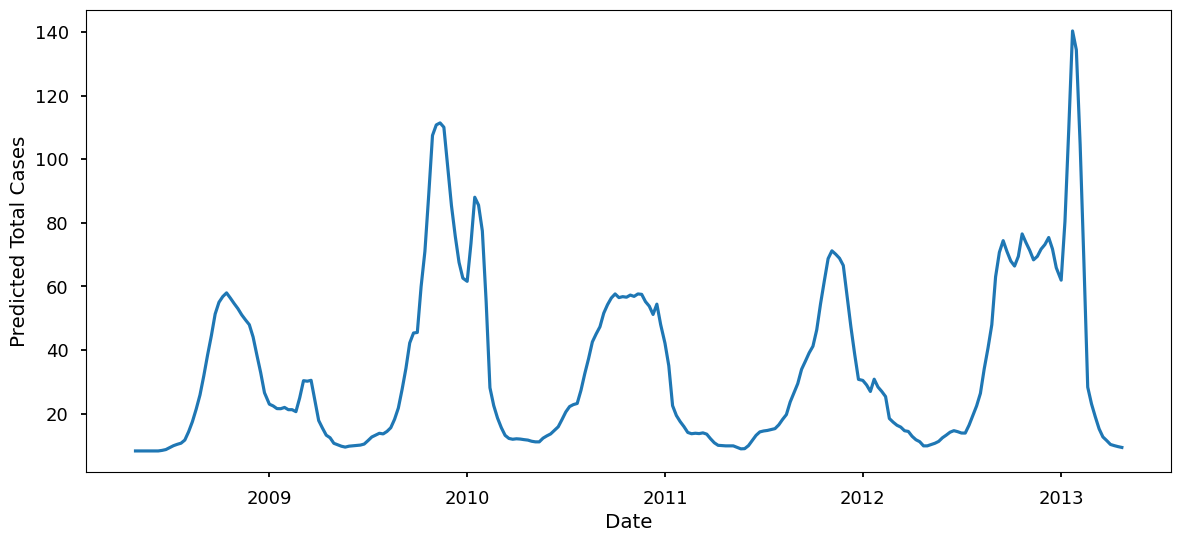

In [91]:
# Zoom on to the final predictions to find the corresponding the years for the peaks. 
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(14,6)) 
  ax.plot(predicted_test_final_rolled, label='test - forecasted') 
  ax.set_xlabel('Date')
  ax.set_ylabel('Predicted Total Cases')
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout();
  fig.savefig('XGB_Forecast_Only.png', dpi=300, bbox_inches='tight')
  files.download("XGB_Forecast_Only.png") 

**Best permorning model predicts two more peaks by the end of years 2009 and 2012**

#### Visualize feature importance:

In [92]:
# Calculate Feature Importance
feature_importances = final_model.feature_importances_
importance = pd.Series(feature_importances, index=X_train_whole.columns) # always positive value?
importance.sort_values()

month                                             0.017704
station_avg_temp_c_shift_18                       0.041669
watery_shift_20                                   0.045804
reanalysis_precip_amt_kg_per_m2_shift_8           0.046078
reanalysis_tdtr_k_shift_8                         0.064036
grassy_shift_20                                   0.064926
soily_shift_20                                    0.108604
station_min_temp_c_shift_18                       0.148184
station_max_temp_c_shift_18                       0.192583
reanalysis_specific_humidity_g_per_kg_shift_12    0.270411
dtype: float32

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

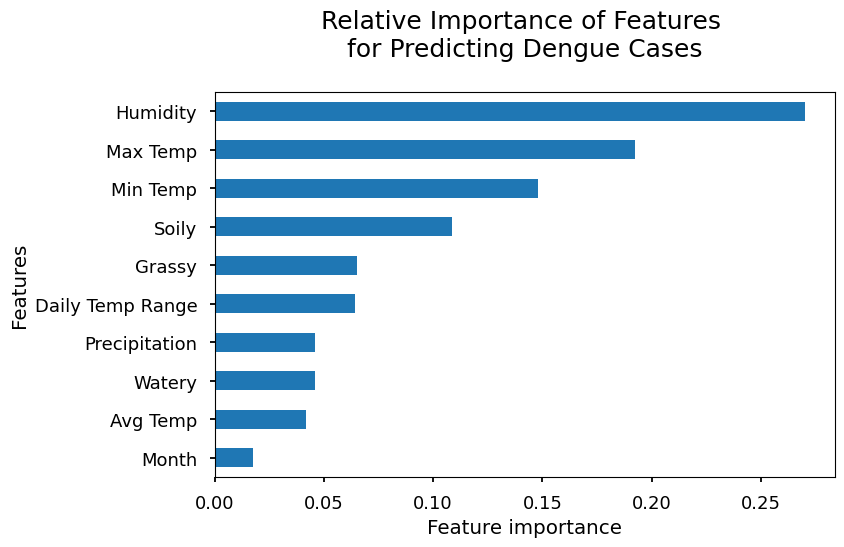

In [93]:
# Visualise Feature Importance
with plt.style.context('seaborn-talk'):
  fig, ax = plt.subplots(figsize=(8,5))
  importance.sort_values().plot.barh(ax=ax);
  ax.set_title("Relative Importance of Features \n for Predicting Dengue Cases \n", fontsize=18) 
  ax.set_xlabel('Feature importance')
  ax.set_ylabel('Features')
  ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
  ax.set_yticklabels(['Month','Avg Temp','Watery','Precipitation','Daily Temp Range','Grassy', 'Soily','Min Temp','Max Temp','Humidity'])
  fig.patch.set_alpha(0) # make the figure background transparent
  # plt.tight_layout()
  fig.savefig('XGB_FeatureImportance.png', dpi=300, bbox_inches='tight')
  files.download("XGB_FeatureImportance.png")       

* Sustained humidity (for 12 weeks) and sustained maximum temperature (for 16 weeks) are the two most important features in predicting dengue cases.

# LSTM Neural Network
***

* You need an input shape of 3D tensor with shape (batch_size, timesteps, input_dim)

#### How to Scale and transform the data for neural network:

* Step 1: fit the scaler on the TRAIN data
* Step 2: use the scaler to transform the TRAINING data
* Step 3: use the transformed training data to fit the predictive model
* Step 4: use the scaler to transform the TEST data
* Step 5: predict using the trained model and the transformed TEST data.

In [94]:
train_LSTM = train_final.copy()

In [95]:
# Create a subset of the bigger dataset
train_LSTM1 = train_LSTM[['total_cases', 'month', 'station_max_temp_c', 'station_min_temp_c',
       'station_avg_temp_c', 'reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_precip_amt_kg_per_m2', 'grassy', 'soily',
       'watery']].copy()

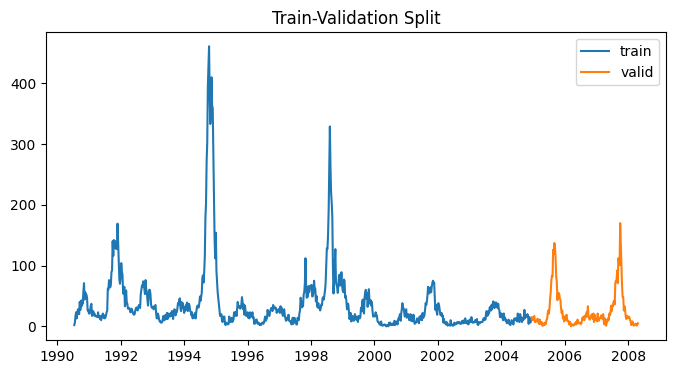

In [96]:
# test train split
train = train_LSTM1.head(750)
test = train_LSTM1.tail(train_LSTM1.shape[0] - 750)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train.total_cases, label='train')
ax.plot(test.total_cases, label='valid')
ax.set_title('Train-Validation Split')
plt.legend();

In [97]:
# Train and test X,y:
# the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
X_train, y_train = train.drop('total_cases', axis=1).copy(), train[['total_cases']].copy() 
X_test, y_test = test.drop('total_cases', axis=1).copy(), test[['total_cases']].copy() 

In [98]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 10), (175, 10), (750, 1), (175, 1))

In [99]:
# scale X and y using the sklearn MinMaxScaler model, so that their range will be from 0 to 1.
Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(scaled_X_train.shape)

Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)

# We need the shape of y to be (n, ), where n is the number of rows. 
# remove the second dimention from y so the shape changes from (n,1) to (n,)
scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)

# print(type(scaled_X_train))  # Making sure they are numpy arrays
# print(type(scaled_y_train)) 

(750, 10)
(750, 1)
(750,)


### Transform with TimeseriesGenerator:
* The TimeseriesGenerator transforms the separate X and y into a structure of samples ready to train deep learning models. 
*  The shape should be (batch_size,n_input,n_features)
* If batch size is equal to 3, the model will input the 3 sample videos and only after that 3 inputs, it will update the weights

In [100]:
# Create the train data
b_size = 32 #len(X_train)           # Number of timeseries samples in each batch
n_input = 12                        # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= scaled_X_train.shape[1] # how many predictors/Xs/features we have to predict y

train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

# The shape should be (batch_size,n_input,n_features)
print(train_generator[0][0].shape)

(32, 12, 10)


In [101]:
# Create the test data
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 12, 10)


## LSTM Model # 1:
* Vanilla LSTM with a single hidden layer of LSTM units, and an output layer used to make a prediction.

In [102]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Patience number of 10: the number of epochs to wait before early stop if no progress on the validation set. 
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [104]:
# fit the model and plot the losses
def LSTM_fit_plotloss(train, test):
  random.seed(48) 
  model.fit(train, epochs=100, verbose = 0, validation_data=test, callbacks=[early_stop])
  loss_per_epoch = model.history.history['loss']
  val_loss_per_epoch = model.history.history['val_loss']
  plt.plot(range(len(loss_per_epoch)),loss_per_epoch, label = 'train_loss');
  plt.plot(range(len(val_loss_per_epoch)),val_loss_per_epoch, label = 'test_loss')
  plt.legend()

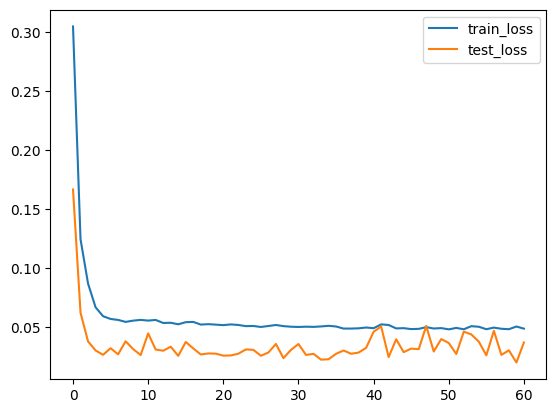

In [105]:
 LSTM_fit_plotloss(train_generator, test_generator)

* Train and test loss converge after 60 epochs.
* Now the model is ready to use and we can make predictions on the train and test set.

In [106]:
# Make predictions on train and test
y_train_pred_scaled = model.predict(train_generator)
y_train_pred = Yscaler.inverse_transform(y_train_pred_scaled)
train_prediction = pd.DataFrame({'y_true':y_train['total_cases'].values[n_input:],
                                'y_pred':y_train_pred.ravel()},
                                 index=y_train.index[n_input:])
  
y_test_pred_scaled = model.predict(test_generator)
y_test_pred = Yscaler.inverse_transform(y_test_pred_scaled)
test_prediction = pd.DataFrame({'y_true':y_test['total_cases'].values[n_input:],
                                  'y_pred':y_test_pred.ravel()},
                                 index=y_test.index[n_input:])

6/6 [==============================] - 0s 6ms/step


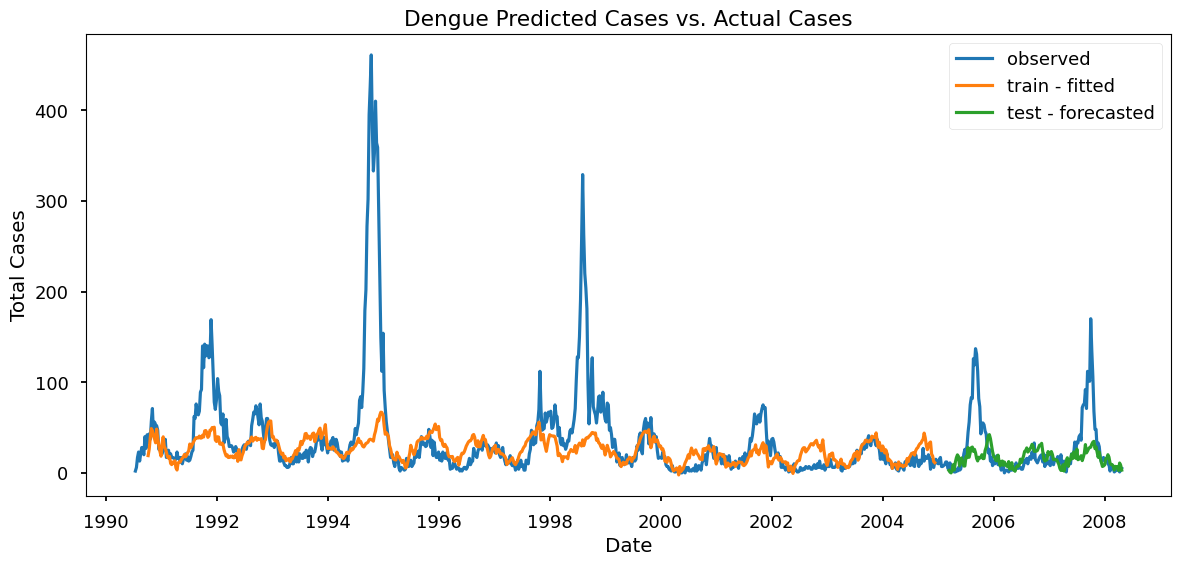

In [107]:
forecast_graph(train_LSTM.total_cases, train_prediction.y_pred, test_prediction.y_pred)

In [108]:
# Print the scores for both train and test
final_scores(train_prediction.y_true, train_prediction.y_pred, 
             test_prediction.y_true, test_prediction.y_pred)

MAE_train: 21.872089
MAE_test: 18.113181
-----------------------
RMSE_train: 52.149597
RMSE_test: 31.650360


**Summary:**

* The model captures the basic seasonality, while missing all the individual ourbreaks - peaks for not only test but also train.
* Let's make the model deeper , more complex by adding layers and neurons.

## LSTM #2:
*  A deeper model with more layers and neurons

In [109]:
# instantiate the model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_input, n_features), return_sequences=True)) # returns a sequence of vectors of dimension 64
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True)) # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
model.add(LSTM(32)) # return a single vector of dimension 32
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12, 128)           71168     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)               

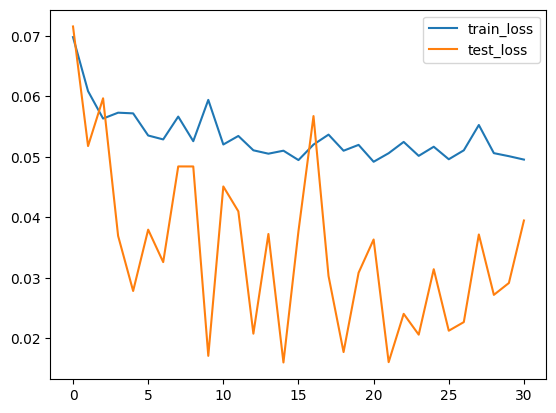

In [110]:
LSTM_fit_plotloss(train_generator, test_generator)

In [111]:
y_train_pred_scaled = model.predict(train_generator)
y_train_pred = Yscaler.inverse_transform(y_train_pred_scaled)
train_prediction = pd.DataFrame({'y_true':y_train['total_cases'].values[n_input:],
                                'y_pred':y_train_pred.ravel()},
                                 index=y_train.index[n_input:])
  
y_test_pred_scaled = model.predict(test_generator)
y_test_pred = Yscaler.inverse_transform(y_test_pred_scaled)
test_prediction = pd.DataFrame({'y_true':y_test['total_cases'].values[n_input:],
                                  'y_pred':y_test_pred.ravel()},
                                 index=y_test.index[n_input:])

6/6 [==============================] - 0s 19ms/step


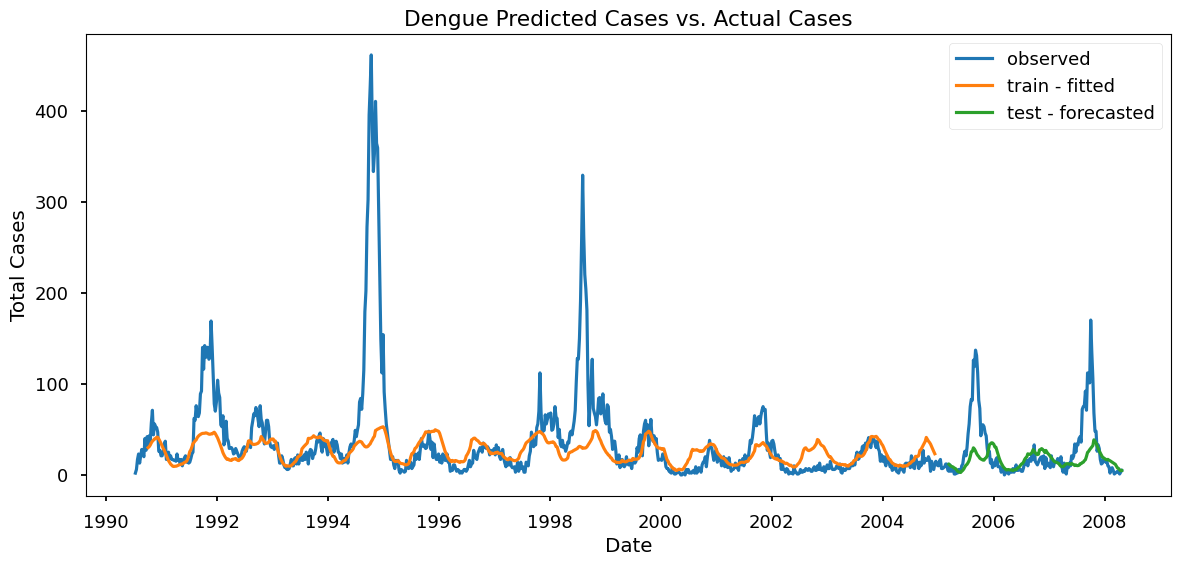

In [112]:
forecast_graph(train_LSTM1.total_cases, train_prediction.y_pred, test_prediction.y_pred)

In [113]:
final_scores(train_prediction.y_true, train_prediction.y_pred, test_prediction.y_true, test_prediction.y_pred)

MAE_train: 21.994982
MAE_test: 18.276054
-----------------------
RMSE_train: 52.422382
RMSE_test: 31.680940


**Summary:**

* Increasing complexity improved the MAE and RMSE scores very slightly and it was not enough to be able to detect the individual peaks /outbreaks for train and test. 
* Next, let's use lagged variables to see if that would make a difference like it did for NBR and XGBoost.

## LSTM #3
* Lagged variables and a deeper model

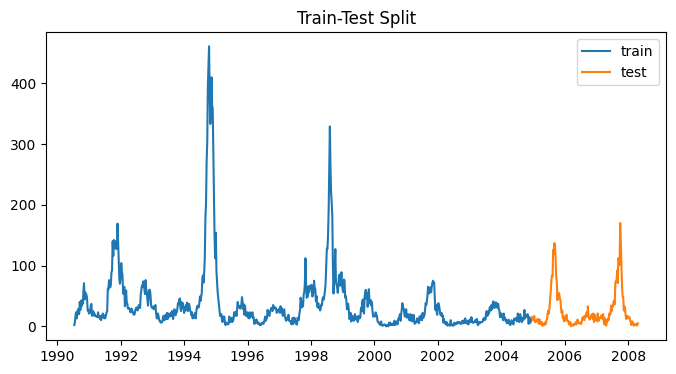

In [114]:
train_LSTM3 = train_LSTM[['total_cases', 'month',
                          'station_max_temp_c_shift_18', 'station_min_temp_c_shift_18',
                          'station_avg_temp_c_shift_18', 'reanalysis_tdtr_k_shift_8','reanalysis_specific_humidity_g_per_kg_shift_12',
                          'reanalysis_precip_amt_kg_per_m2_shift_8', 'soily_shift_20', 'grassy_shift_20',
                          'watery_shift_20']].copy()

train_data = train_LSTM3.head(750)
test_data = train_LSTM3.tail(train_LSTM3.shape[0] - 750)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train_data.total_cases, label='train')
ax.plot(test_data.total_cases, label='test')
ax.set_title('Train-Test Split');
plt.legend()

X_train, y_train = train_data.drop('total_cases', axis=1).copy(), train_data[['total_cases']].copy() 
X_test, y_test = test_data.drop('total_cases', axis=1).copy(), test_data[['total_cases']].copy() 

In [115]:
# scale X and y using the sklearn MinMaxScaler model, so that their range will be from 0 to 1.
Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(scaled_X_train.shape)

Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)

# We need the shape of y to be (n, ), where n is the number of rows. 
# remove the second dimention from y so the shape changes from (n,1) to (n,)
scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)


(750, 10)
(750, 1)
(750,)


In [116]:
b_size = 32                         # len(X_train) Number of timeseries samples in each batch
n_input = 12                        # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= scaled_X_train.shape[1] # how many predictors/Xs/features we have to predict y

train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

# The shape should be (batch_size,n_input,n_features)
print(train_generator[0][0].shape)

(32, 12, 10)


In [117]:
# create the validation data
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 12, 10)


In [118]:
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True)) # returns a sequence of vectors of dimension 64
model.add(Dropout(0.2))
model.add(LSTM(32)) # return a single vector of dimension 32
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 512)           1071104   
                                                                 
 dropout_4 (Dropout)         (None, 12, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 12, 256)           787456    
                                                                 
 dropout_5 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_6 (LSTM)               (None, 12, 128)           197120    
                                                                 
 dropout_6 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 12, 64)           

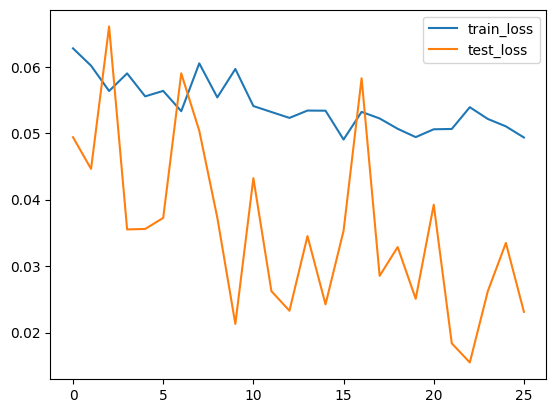

In [119]:
# fit the model and plot the losses
LSTM_fit_plotloss(train_generator, test_generator)

In [120]:
# create predictions
y_train_pred_scaled = model.predict(train_generator)
y_train_pred = Yscaler.inverse_transform(y_train_pred_scaled)
train_prediction = pd.DataFrame({'y_true':y_train['total_cases'].values[n_input:],
                                'y_pred':y_train_pred.ravel()},
                                 index=y_train.index[n_input:])
  
y_test_pred_scaled = model.predict(test_generator)
y_test_pred = Yscaler.inverse_transform(y_test_pred_scaled)
test_prediction = pd.DataFrame({'y_true':y_test['total_cases'].values[n_input:],
                                  'y_pred':y_test_pred.ravel()},
                                 index=y_test.index[n_input:])

6/6 [==============================] - 0s 58ms/step


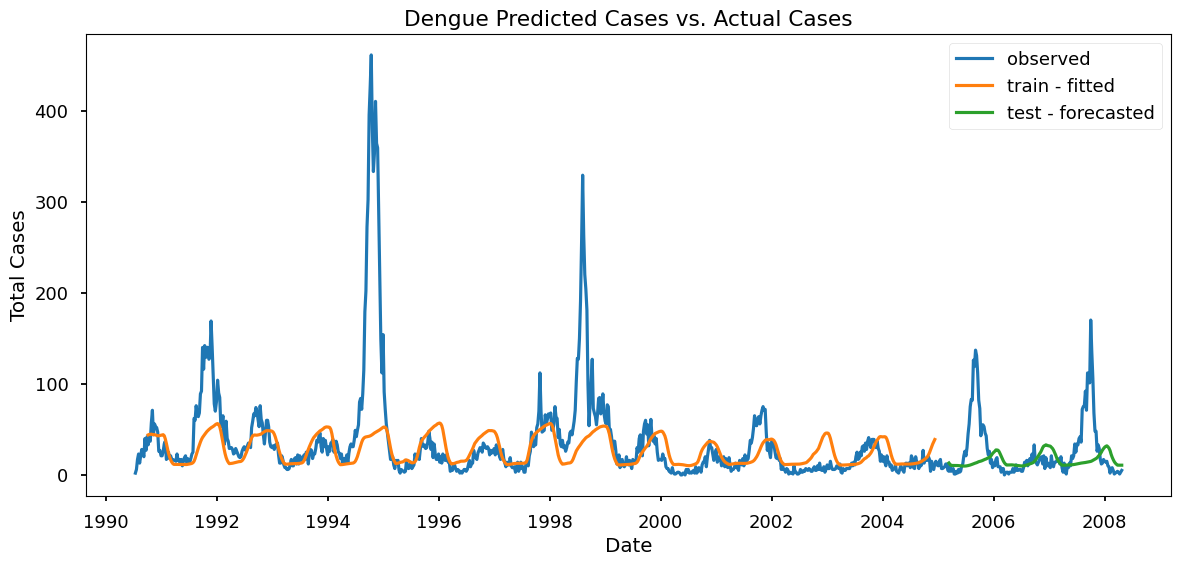

In [121]:
forecast_graph(train_LSTM.total_cases, train_prediction['y_pred'], test_prediction['y_pred'])

In [122]:
final_scores(train_prediction.y_true, train_prediction.y_pred, test_prediction.y_true, test_prediction.y_pred)

MAE_train: 22.213241
MAE_test: 21.668057
-----------------------
RMSE_train: 51.646726
RMSE_test: 35.927098


**Summary:**

* Using the best performing lagged variables with increased neural network complexity improved the model again very slightly but it is still unable to detect individual peaks/outbreaks. 
* We probably need a much more complex model since we are not able to detect even the peaks of the train set. 


## Conclusions / Recommendations:
***
* Dengue cases rely on climate variables, but the relationship is complex.
* Further models should take into consideration cumulative computations of climate features over a period rather than isolated numbers.
* Climate change and global warming may make dengue outbreaks and similar mosquito born illnesses more deadly in the future.
* Knowing the next outbreak would help countries to allocate more resources to the health care system for timely intervention.

## Limitations, Improvements, Next Steps
***
* More recent data needs to be collected to achieve more accurate predictions.  
* Since the relationship between dengue and climate is complex:
  * Nonlinear relationships need to be taken into account with more complex models.
  * More meaningful and complex climate related features need to be engineered. 

### Export as PDF:

In [123]:
# Packages required for using nbconvert PDF
# ! apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# ! pip install pypandoc
# ! pip install nbconvert

In [124]:
# First you need to download a copy of the ipynb notebook and upload it back to the drive, it is placed under /content/
# ! jupyter nbconvert --to pdf /content/notebook_modeling.ipynb